# 2D Fine Regular Triangulations

This notebook trains the diffusion model on a dataset containing fine regular triangulations of an 8x8 grid. For more information about the dataset, see the notebook under datasets/triangulations.

Regular triangulations in higher dimensions play a crucial role in constructing Calabi-Yau manifolds and the associated solutions of string theory. This toy example is a first step towards generating Calabi-Yau manifolds with diffusion models.

A triangulation of a set of points is called regular if it can be generated as follows. Lift every point into one higher dimension, where a height is assigned to each point. Take the convex hull of the resulting set of points and project down the downward-facing faces of this polyhedron to obtain a triangulation. Not all triangulations can be obtained this way, i.e., not every triangulation is regular.

A triangulation of a set of points is called fine if every point is included in the triangulation.

In this dataset, for every regular triangulation we generate a 2D image where the values of the pixels are the heights of the points. Then, we train the diffusion model on these images. For inference, we use the diffusion model to generate a 2D image of heights and use CYTools (https://cy.tools/) to convert them into triangulations.

In [1]:
# Import
from Diffusion import *
from utils import makedir
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
import h5py as h5
import pickle
import os

torch.set_float32_matmul_precision('medium')

In [2]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_path = local_storage_dir + "Datasets/triangulations/dataset.h5"
checkpoint_dir = local_storage_dir + "Checkpoints/triangulations/"
log_dir = local_storage_dir + "Logs/triangulations/"
sample_dir = os.getcwd() + "/triangulate/samples/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(sample_dir)
makedir(gif_dir)
num_channels = 1 # 1 for grayscale
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 8
batch_size = 2**12
max_dataset_size = -1 # Set to -1 to use the entire dataset

In [3]:
# Load dataset
class hdf5Dataset(Dataset):
    def __init__(self, dataset_path, load_all=False, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.load_all = load_all
        if load_all:
            self.dataset = h5.File(dataset_path, 'r')['height_images'][:]
            self.dataset = self.dataset[:,None,:,:]
            self.dataset = torch.from_numpy(self.dataset).float()
        else:
            self.dataset = h5.File(dataset_path, 'r')['height_images']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.load_all:
            image = self.dataset[idx]
        else:
            image = self.dataset[idx][None,:,:]
            image = torch.from_numpy(image).float()
        if self.transform:
            image = self.transform(image)
        return image        

scale_factor = 16 # Scale the images to make sure noising is not too weak or too strong
transform = transforms.Lambda(lambda t: scale_factor*t) 

image_dataset = hdf5Dataset(dataset_path, load_all=False, transform=transform)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, drop_last=True,
                         num_workers=16, pin_memory=True, persistent_workers=True, prefetch_factor=2)

In [4]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

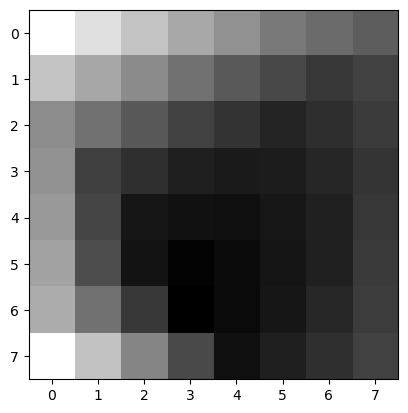

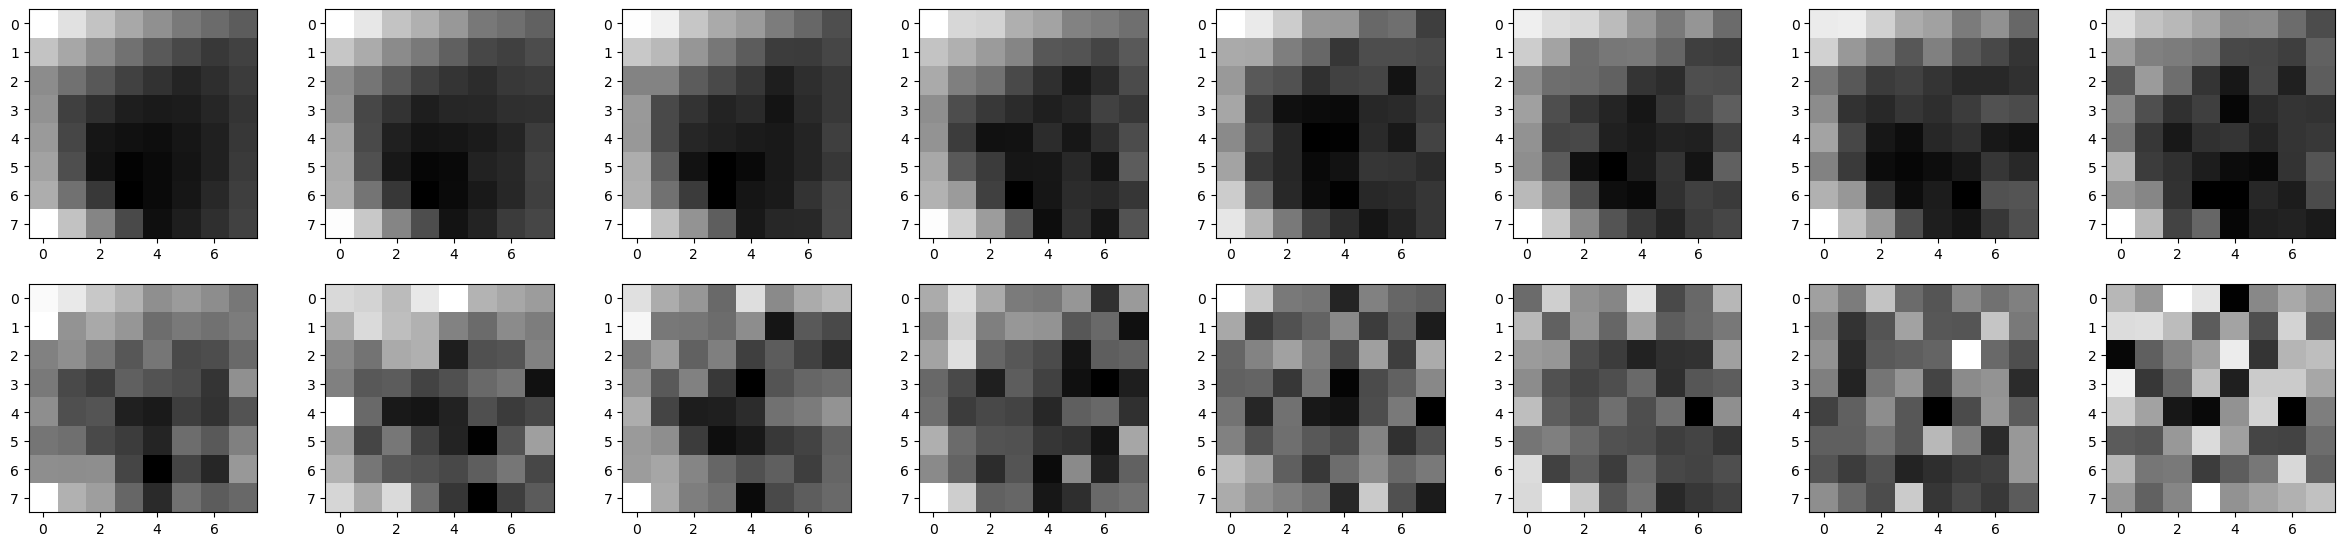

In [11]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]), cmap='gray')

plt.figure(figsize=(30,60))
num_images = 16
stepsize = int(num_timesteps/num_images)
for idx in range(0, num_timesteps):
    if idx % stepsize == 0:
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
        tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
        plt.imshow(image_from_tensor(tensor[0]), cmap="gray")

In [5]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=64,
    num_downsamples=2,
    num_mid_convs=1
    )
print("Num params: ", sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995, last_epoch=-1, verbose=False)

Num params:  3780865


In [7]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = False
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model, optimizer, lr_scheduler)
    
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=500,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=50,
    log_dir=log_dir+timestamp
    )

  0%|          | 0/256 [00:00<?, ?it/s]/tmp/torchinductor_md775/dn/cdn7eyraoqzosvkg4zldt7pyu7fupd5e4odd4fgaevve7xn7gwdu.py:2331: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  buf0 = extern_kernels.convolution(primals_111, primals_1, stride=(1, 1), padding=(1, 1), dilation=(1, 1), transposed=False, output_padding=(0, 0), groups=1, bias=None)
100%|██████████| 256/256 [00:40<00:00,  6.37it/s, Epoch:=1, LR:=0.001, Loss:=0.616]


Epoch: 1 Loss: 0.616159247700125
LR: 0.000995


100%|██████████| 256/256 [00:15<00:00, 16.91it/s, Epoch:=2, LR:=0.000995, Loss:=0.505]


Epoch: 2 Loss: 0.504528277204372
LR: 0.000990025


100%|██████████| 256/256 [00:15<00:00, 16.78it/s, Epoch:=3, LR:=0.00099, Loss:=0.482]


Epoch: 3 Loss: 0.4824069911846891
LR: 0.000985074875


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=4, LR:=0.000985, Loss:=0.47] 


Epoch: 4 Loss: 0.4697217420907691
LR: 0.000980149500625


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=5, LR:=0.00098, Loss:=0.458]


Epoch: 5 Loss: 0.45762239524628967
LR: 0.000975248753121875


100%|██████████| 256/256 [00:15<00:00, 16.86it/s, Epoch:=6, LR:=0.000975, Loss:=0.447]


Epoch: 6 Loss: 0.4468436741735786
LR: 0.0009703725093562657


100%|██████████| 256/256 [00:15<00:00, 16.75it/s, Epoch:=7, LR:=0.00097, Loss:=0.438]


Epoch: 7 Loss: 0.4377052537165582
LR: 0.0009655206468094843


100%|██████████| 256/256 [00:15<00:00, 16.90it/s, Epoch:=8, LR:=0.000966, Loss:=0.432]


Epoch: 8 Loss: 0.43206681951414794
LR: 0.0009606930435754369


100%|██████████| 256/256 [00:15<00:00, 16.90it/s, Epoch:=9, LR:=0.000961, Loss:=0.427]


Epoch: 9 Loss: 0.4268086589872837
LR: 0.0009558895783575597


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=10, LR:=0.000956, Loss:=0.424]


Epoch: 10 Loss: 0.4236308201216161
LR: 0.0009511101304657719


100%|██████████| 256/256 [00:15<00:00, 17.03it/s, Epoch:=11, LR:=0.000951, Loss:=0.421]


Epoch: 11 Loss: 0.42078008269891143
LR: 0.000946354579813443


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=12, LR:=0.000946, Loss:=0.417]


Epoch: 12 Loss: 0.41746807063464075
LR: 0.0009416228069143757


100%|██████████| 256/256 [00:15<00:00, 16.84it/s, Epoch:=13, LR:=0.000942, Loss:=0.416]


Epoch: 13 Loss: 0.4155558835482225
LR: 0.0009369146928798038


100%|██████████| 256/256 [00:15<00:00, 16.97it/s, Epoch:=14, LR:=0.000937, Loss:=0.414]


Epoch: 14 Loss: 0.41384887124877423
LR: 0.0009322301194154048


100%|██████████| 256/256 [00:15<00:00, 16.87it/s, Epoch:=15, LR:=0.000932, Loss:=0.412]


Epoch: 15 Loss: 0.41240237606689334
LR: 0.0009275689688183278


100%|██████████| 256/256 [00:14<00:00, 17.11it/s, Epoch:=16, LR:=0.000928, Loss:=0.41] 


Epoch: 16 Loss: 0.410423056804575
LR: 0.0009229311239742361


100%|██████████| 256/256 [00:15<00:00, 16.90it/s, Epoch:=17, LR:=0.000923, Loss:=0.409]


Epoch: 17 Loss: 0.4092792593874037
LR: 0.0009183164683543649


100%|██████████| 256/256 [00:15<00:00, 16.94it/s, Epoch:=18, LR:=0.000918, Loss:=0.408]


Epoch: 18 Loss: 0.40806730161421
LR: 0.0009137248860125931


100%|██████████| 256/256 [00:15<00:00, 17.05it/s, Epoch:=19, LR:=0.000914, Loss:=0.406]


Epoch: 19 Loss: 0.4063508021645248
LR: 0.0009091562615825302


100%|██████████| 256/256 [00:15<00:00, 17.02it/s, Epoch:=20, LR:=0.000909, Loss:=0.405]


Epoch: 20 Loss: 0.4051273607183248
LR: 0.0009046104802746175


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=21, LR:=0.000905, Loss:=0.405]


Epoch: 21 Loss: 0.40487462643068284
LR: 0.0009000874278732445


100%|██████████| 256/256 [00:15<00:00, 16.86it/s, Epoch:=22, LR:=0.0009, Loss:=0.403]


Epoch: 22 Loss: 0.40319750632625073
LR: 0.0008955869907338783


100%|██████████| 256/256 [00:14<00:00, 17.15it/s, Epoch:=23, LR:=0.000896, Loss:=0.403]


Epoch: 23 Loss: 0.4027211966458708
LR: 0.0008911090557802089


100%|██████████| 256/256 [00:15<00:00, 16.97it/s, Epoch:=24, LR:=0.000891, Loss:=0.401]


Epoch: 24 Loss: 0.4013546876376495
LR: 0.0008866535105013078


100%|██████████| 256/256 [00:15<00:00, 17.02it/s, Epoch:=25, LR:=0.000887, Loss:=0.4]  


Epoch: 25 Loss: 0.4004896393744275
LR: 0.0008822202429488013


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=26, LR:=0.000882, Loss:=0.4] 


Epoch: 26 Loss: 0.4001087413635105
LR: 0.0008778091417340573


100%|██████████| 256/256 [00:15<00:00, 17.01it/s, Epoch:=27, LR:=0.000878, Loss:=0.399]


Epoch: 27 Loss: 0.39898639207240194
LR: 0.000873420096025387


100%|██████████| 256/256 [00:15<00:00, 16.98it/s, Epoch:=28, LR:=0.000873, Loss:=0.398]


Epoch: 28 Loss: 0.39844908006489277
LR: 0.0008690529955452601


100%|██████████| 256/256 [00:15<00:00, 16.96it/s, Epoch:=29, LR:=0.000869, Loss:=0.397]


Epoch: 29 Loss: 0.3974147983826697
LR: 0.0008647077305675338


100%|██████████| 256/256 [00:15<00:00, 16.98it/s, Epoch:=30, LR:=0.000865, Loss:=0.397]


Epoch: 30 Loss: 0.3968823474133387
LR: 0.0008603841919146961


100%|██████████| 256/256 [00:15<00:00, 17.05it/s, Epoch:=31, LR:=0.00086, Loss:=0.396]


Epoch: 31 Loss: 0.39640435844194144
LR: 0.0008560822709551226


100%|██████████| 256/256 [00:15<00:00, 16.97it/s, Epoch:=32, LR:=0.000856, Loss:=0.396]


Epoch: 32 Loss: 0.3957161874277517
LR: 0.000851801859600347


100%|██████████| 256/256 [00:15<00:00, 16.96it/s, Epoch:=33, LR:=0.000852, Loss:=0.395]


Epoch: 33 Loss: 0.3950608049053699
LR: 0.0008475428503023452


100%|██████████| 256/256 [00:15<00:00, 16.92it/s, Epoch:=34, LR:=0.000848, Loss:=0.395]


Epoch: 34 Loss: 0.39484262943733484
LR: 0.0008433051360508335


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=35, LR:=0.000843, Loss:=0.394]


Epoch: 35 Loss: 0.3938875973690301
LR: 0.0008390886103705794


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=36, LR:=0.000839, Loss:=0.394]


Epoch: 36 Loss: 0.3939729619305581
LR: 0.0008348931673187264


100%|██████████| 256/256 [00:15<00:00, 17.02it/s, Epoch:=37, LR:=0.000835, Loss:=0.393]


Epoch: 37 Loss: 0.39271523791830987
LR: 0.0008307187014821328


100%|██████████| 256/256 [00:15<00:00, 16.95it/s, Epoch:=38, LR:=0.000831, Loss:=0.392]


Epoch: 38 Loss: 0.3918626375962049
LR: 0.0008265651079747222


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=39, LR:=0.000827, Loss:=0.392]


Epoch: 39 Loss: 0.39215310639701784
LR: 0.0008224322824348485


100%|██████████| 256/256 [00:15<00:00, 16.87it/s, Epoch:=40, LR:=0.000822, Loss:=0.391]


Epoch: 40 Loss: 0.3914049764862284
LR: 0.0008183201210226743


100%|██████████| 256/256 [00:15<00:00, 16.85it/s, Epoch:=41, LR:=0.000818, Loss:=0.391]


Epoch: 41 Loss: 0.390508865355514
LR: 0.0008142285204175609


100%|██████████| 256/256 [00:14<00:00, 17.13it/s, Epoch:=42, LR:=0.000814, Loss:=0.391]


Epoch: 42 Loss: 0.39100332697853446
LR: 0.0008101573778154731


100%|██████████| 256/256 [00:14<00:00, 17.15it/s, Epoch:=43, LR:=0.00081, Loss:=0.39] 


Epoch: 43 Loss: 0.39027646696195006
LR: 0.0008061065909263957


100%|██████████| 256/256 [00:15<00:00, 16.97it/s, Epoch:=44, LR:=0.000806, Loss:=0.389]


Epoch: 44 Loss: 0.3894177672918886
LR: 0.0008020760579717638


100%|██████████| 256/256 [00:15<00:00, 16.84it/s, Epoch:=45, LR:=0.000802, Loss:=0.389]


Epoch: 45 Loss: 0.38943716883659363
LR: 0.000798065677681905


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=46, LR:=0.000798, Loss:=0.388]


Epoch: 46 Loss: 0.3884723265655339
LR: 0.0007940753492934955


100%|██████████| 256/256 [00:15<00:00, 16.96it/s, Epoch:=47, LR:=0.000794, Loss:=0.389]


Epoch: 47 Loss: 0.3888442034367472
LR: 0.000790104972547028


100%|██████████| 256/256 [00:15<00:00, 16.78it/s, Epoch:=48, LR:=0.00079, Loss:=0.388]


Epoch: 48 Loss: 0.3878679109038785
LR: 0.0007861544476842928


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=49, LR:=0.000786, Loss:=0.388]


Epoch: 49 Loss: 0.38757993292529136
LR: 0.0007822236754458713


100%|██████████| 256/256 [00:15<00:00, 16.98it/s, Epoch:=50, LR:=0.000782, Loss:=0.387]


Epoch: 50 Loss: 0.38723905198276043
LR: 0.0007783125570686419


100%|██████████| 256/256 [00:14<00:00, 17.10it/s, Epoch:=51, LR:=0.000778, Loss:=0.387]


Epoch: 51 Loss: 0.3868284662021324
LR: 0.0007744209942832988


100%|██████████| 256/256 [00:15<00:00, 17.04it/s, Epoch:=52, LR:=0.000774, Loss:=0.387]


Epoch: 52 Loss: 0.3870572041487321
LR: 0.0007705488893118823


100%|██████████| 256/256 [00:15<00:00, 16.85it/s, Epoch:=53, LR:=0.000771, Loss:=0.386]


Epoch: 53 Loss: 0.38626099133398384
LR: 0.0007666961448653228


100%|██████████| 256/256 [00:15<00:00, 16.83it/s, Epoch:=54, LR:=0.000767, Loss:=0.386]


Epoch: 54 Loss: 0.38620253873523325
LR: 0.0007628626641409962


100%|██████████| 256/256 [00:15<00:00, 17.02it/s, Epoch:=55, LR:=0.000763, Loss:=0.386]


Epoch: 55 Loss: 0.3856395692564547
LR: 0.0007590483508202912


100%|██████████| 256/256 [00:15<00:00, 16.92it/s, Epoch:=56, LR:=0.000759, Loss:=0.386]


Epoch: 56 Loss: 0.38578504126053303
LR: 0.0007552531090661898


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=57, LR:=0.000755, Loss:=0.385]


Epoch: 57 Loss: 0.3847713090945035
LR: 0.0007514768435208588


100%|██████████| 256/256 [00:15<00:00, 16.91it/s, Epoch:=58, LR:=0.000751, Loss:=0.385]


Epoch: 58 Loss: 0.38465480122249573
LR: 0.0007477194593032545


100%|██████████| 256/256 [00:15<00:00, 16.95it/s, Epoch:=59, LR:=0.000748, Loss:=0.384]


Epoch: 59 Loss: 0.38407659775111824
LR: 0.0007439808620067382


100%|██████████| 256/256 [00:14<00:00, 17.08it/s, Epoch:=60, LR:=0.000744, Loss:=0.384]


Epoch: 60 Loss: 0.384459096705541
LR: 0.0007402609576967046


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=61, LR:=0.00074, Loss:=0.384]


Epoch: 61 Loss: 0.3840281014563516
LR: 0.000736559652908221


100%|██████████| 256/256 [00:15<00:00, 16.96it/s, Epoch:=62, LR:=0.000737, Loss:=0.383]


Epoch: 62 Loss: 0.38318763650022447
LR: 0.0007328768546436799


100%|██████████| 256/256 [00:15<00:00, 16.90it/s, Epoch:=63, LR:=0.000733, Loss:=0.383]


Epoch: 63 Loss: 0.38330862333532423
LR: 0.0007292124703704615


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=64, LR:=0.000729, Loss:=0.383]


Epoch: 64 Loss: 0.38333205494564027
LR: 0.0007255664080186091


100%|██████████| 256/256 [00:15<00:00, 16.84it/s, Epoch:=65, LR:=0.000726, Loss:=0.383]


Epoch: 65 Loss: 0.3834785451181233
LR: 0.0007219385759785161


100%|██████████| 256/256 [00:15<00:00, 16.96it/s, Epoch:=66, LR:=0.000722, Loss:=0.383]


Epoch: 66 Loss: 0.38264835299924016
LR: 0.0007183288830986235


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=67, LR:=0.000718, Loss:=0.382]


Epoch: 67 Loss: 0.38196735887322575
LR: 0.0007147372386831303


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=68, LR:=0.000715, Loss:=0.382]


Epoch: 68 Loss: 0.38237924803979695
LR: 0.0007111635524897147


100%|██████████| 256/256 [00:15<00:00, 17.01it/s, Epoch:=69, LR:=0.000711, Loss:=0.382]


Epoch: 69 Loss: 0.38163205585442483
LR: 0.0007076077347272661


100%|██████████| 256/256 [00:15<00:00, 16.98it/s, Epoch:=70, LR:=0.000708, Loss:=0.382]


Epoch: 70 Loss: 0.3818648159503937
LR: 0.0007040696960536298


100%|██████████| 256/256 [00:15<00:00, 16.87it/s, Epoch:=71, LR:=0.000704, Loss:=0.381]


Epoch: 71 Loss: 0.3813344977097586
LR: 0.0007005493475733617


100%|██████████| 256/256 [00:15<00:00, 16.80it/s, Epoch:=72, LR:=0.000701, Loss:=0.381]


Epoch: 72 Loss: 0.3810692662373185
LR: 0.0006970466008354948


100%|██████████| 256/256 [00:15<00:00, 17.00it/s, Epoch:=73, LR:=0.000697, Loss:=0.381]


Epoch: 73 Loss: 0.380981897120364
LR: 0.0006935613678313174


100%|██████████| 256/256 [00:15<00:00, 17.07it/s, Epoch:=74, LR:=0.000694, Loss:=0.381]


Epoch: 74 Loss: 0.3808550181565806
LR: 0.0006900935609921607


100%|██████████| 256/256 [00:15<00:00, 16.95it/s, Epoch:=75, LR:=0.00069, Loss:=0.38]


Epoch: 75 Loss: 0.38030510349199176
LR: 0.0006866430931872


100%|██████████| 256/256 [00:15<00:00, 16.83it/s, Epoch:=76, LR:=0.000687, Loss:=0.381]


Epoch: 76 Loss: 0.38052712788339704
LR: 0.000683209877721264


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=77, LR:=0.000683, Loss:=0.38]


Epoch: 77 Loss: 0.3800705057801679
LR: 0.0006797938283326577


100%|██████████| 256/256 [00:15<00:00, 16.94it/s, Epoch:=78, LR:=0.00068, Loss:=0.38] 


Epoch: 78 Loss: 0.3797628483735025
LR: 0.0006763948591909945


100%|██████████| 256/256 [00:15<00:00, 17.04it/s, Epoch:=79, LR:=0.000676, Loss:=0.38] 


Epoch: 79 Loss: 0.3799324774881825
LR: 0.0006730128848950395


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=80, LR:=0.000673, Loss:=0.38] 


Epoch: 80 Loss: 0.37980882497504354
LR: 0.0006696478204705643


100%|██████████| 256/256 [00:15<00:00, 16.85it/s, Epoch:=81, LR:=0.00067, Loss:=0.379]


Epoch: 81 Loss: 0.37909420067444444
LR: 0.0006662995813682115


100%|██████████| 256/256 [00:15<00:00, 16.96it/s, Epoch:=82, LR:=0.000666, Loss:=0.379]


Epoch: 82 Loss: 0.3790094420546666
LR: 0.0006629680834613704


100%|██████████| 256/256 [00:15<00:00, 17.07it/s, Epoch:=83, LR:=0.000663, Loss:=0.379]


Epoch: 83 Loss: 0.3790369494818151
LR: 0.0006596532430440636


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=84, LR:=0.00066, Loss:=0.379]


Epoch: 84 Loss: 0.3787141302600503
LR: 0.0006563549768288432


100%|██████████| 256/256 [00:15<00:00, 16.94it/s, Epoch:=85, LR:=0.000656, Loss:=0.378]


Epoch: 85 Loss: 0.37825016560964286
LR: 0.000653073201944699


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=86, LR:=0.000653, Loss:=0.378]


Epoch: 86 Loss: 0.37839024350978434
LR: 0.0006498078359349755


100%|██████████| 256/256 [00:15<00:00, 16.87it/s, Epoch:=87, LR:=0.00065, Loss:=0.378]


Epoch: 87 Loss: 0.3781546368263662
LR: 0.0006465587967553006


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=88, LR:=0.000647, Loss:=0.378]


Epoch: 88 Loss: 0.3780383055564016
LR: 0.0006433260027715241


100%|██████████| 256/256 [00:15<00:00, 16.95it/s, Epoch:=89, LR:=0.000643, Loss:=0.378]


Epoch: 89 Loss: 0.3779913088073954
LR: 0.0006401093727576665


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=90, LR:=0.00064, Loss:=0.378]


Epoch: 90 Loss: 0.3780132347019389
LR: 0.0006369088258938781


100%|██████████| 256/256 [00:15<00:00, 16.93it/s, Epoch:=91, LR:=0.000637, Loss:=0.378]


Epoch: 91 Loss: 0.3782084786798805
LR: 0.0006337242817644087


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=92, LR:=0.000634, Loss:=0.377]


Epoch: 92 Loss: 0.37727915681898594
LR: 0.0006305556603555866


100%|██████████| 256/256 [00:15<00:00, 16.92it/s, Epoch:=93, LR:=0.000631, Loss:=0.377]


Epoch: 93 Loss: 0.3773307306692004
LR: 0.0006274028820538087


100%|██████████| 256/256 [00:15<00:00, 16.98it/s, Epoch:=94, LR:=0.000627, Loss:=0.377]


Epoch: 94 Loss: 0.37709361012093723
LR: 0.0006242658676435396


100%|██████████| 256/256 [00:15<00:00, 16.86it/s, Epoch:=95, LR:=0.000624, Loss:=0.377]


Epoch: 95 Loss: 0.3772051321575418
LR: 0.0006211445383053219


100%|██████████| 256/256 [00:15<00:00, 16.89it/s, Epoch:=96, LR:=0.000621, Loss:=0.377]


Epoch: 96 Loss: 0.3769856608705595
LR: 0.0006180388156137953


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=97, LR:=0.000618, Loss:=0.377]


Epoch: 97 Loss: 0.376940312795341
LR: 0.0006149486215357262


100%|██████████| 256/256 [00:15<00:00, 16.90it/s, Epoch:=98, LR:=0.000615, Loss:=0.376]


Epoch: 98 Loss: 0.37632138724438846
LR: 0.0006118738784280476


100%|██████████| 256/256 [00:15<00:00, 17.00it/s, Epoch:=99, LR:=0.000612, Loss:=0.376]


Epoch: 99 Loss: 0.3757397204171866
LR: 0.0006088145090359073


100%|██████████| 256/256 [00:15<00:00, 16.95it/s, Epoch:=100, LR:=0.000609, Loss:=0.376]


Epoch: 100 Loss: 0.3760370807722211
LR: 0.0006057704364907278


100%|██████████| 256/256 [00:15<00:00, 16.95it/s, Epoch:=101, LR:=0.000606, Loss:=0.376]


Epoch: 101 Loss: 0.37598800484556705
LR: 0.0006027415843082742


100%|██████████| 256/256 [00:15<00:00, 17.00it/s, Epoch:=102, LR:=0.000603, Loss:=0.375]


Epoch: 102 Loss: 0.3754774177214131
LR: 0.0005997278763867329


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=103, LR:=0.0006, Loss:=0.376]


Epoch: 103 Loss: 0.3757704721065238
LR: 0.0005967292370047993


100%|██████████| 256/256 [00:15<00:00, 16.86it/s, Epoch:=104, LR:=0.000597, Loss:=0.375]


Epoch: 104 Loss: 0.37543328246101737
LR: 0.0005937455908197753


100%|██████████| 256/256 [00:15<00:00, 16.81it/s, Epoch:=105, LR:=0.000594, Loss:=0.375]


Epoch: 105 Loss: 0.37493093381635845
LR: 0.0005907768628656764


100%|██████████| 256/256 [00:15<00:00, 16.78it/s, Epoch:=106, LR:=0.000591, Loss:=0.375]


Epoch: 106 Loss: 0.37518213177099824
LR: 0.000587822978551348


100%|██████████| 256/256 [00:15<00:00, 16.49it/s, Epoch:=107, LR:=0.000588, Loss:=0.375]


Epoch: 107 Loss: 0.37503500771708786
LR: 0.0005848838636585913


100%|██████████| 256/256 [00:14<00:00, 17.84it/s, Epoch:=108, LR:=0.000585, Loss:=0.375]


Epoch: 108 Loss: 0.37528137234039605
LR: 0.0005819594443402983


100%|██████████| 256/256 [00:14<00:00, 17.88it/s, Epoch:=109, LR:=0.000582, Loss:=0.375]


Epoch: 109 Loss: 0.37539757520426065
LR: 0.0005790496471185969


100%|██████████| 256/256 [00:14<00:00, 17.93it/s, Epoch:=110, LR:=0.000579, Loss:=0.374]


Epoch: 110 Loss: 0.3743771929293871
LR: 0.0005761543988830039


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=111, LR:=0.000576, Loss:=0.375]


Epoch: 111 Loss: 0.37467697635293007
LR: 0.0005732736268885889


100%|██████████| 256/256 [00:14<00:00, 17.88it/s, Epoch:=112, LR:=0.000573, Loss:=0.374]


Epoch: 112 Loss: 0.37380136107094586
LR: 0.0005704072587541459


100%|██████████| 256/256 [00:14<00:00, 17.87it/s, Epoch:=113, LR:=0.00057, Loss:=0.375]


Epoch: 113 Loss: 0.3746832851320505
LR: 0.0005675552224603752


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=114, LR:=0.000568, Loss:=0.374]


Epoch: 114 Loss: 0.37423665076494217
LR: 0.0005647174463480733


100%|██████████| 256/256 [00:14<00:00, 17.80it/s, Epoch:=115, LR:=0.000565, Loss:=0.374]


Epoch: 115 Loss: 0.3740344156976789
LR: 0.0005618938591163329


100%|██████████| 256/256 [00:14<00:00, 17.87it/s, Epoch:=116, LR:=0.000562, Loss:=0.374]


Epoch: 116 Loss: 0.3738619686337188
LR: 0.0005590843898207513


100%|██████████| 256/256 [00:14<00:00, 17.92it/s, Epoch:=117, LR:=0.000559, Loss:=0.373]


Epoch: 117 Loss: 0.3734150872332975
LR: 0.0005562889678716475


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=118, LR:=0.000556, Loss:=0.373]


Epoch: 118 Loss: 0.3733418917981908
LR: 0.0005535075230322892


100%|██████████| 256/256 [00:14<00:00, 17.87it/s, Epoch:=119, LR:=0.000554, Loss:=0.374]


Epoch: 119 Loss: 0.37373712367843837
LR: 0.0005507399854171277


100%|██████████| 256/256 [00:14<00:00, 18.00it/s, Epoch:=120, LR:=0.000551, Loss:=0.373]


Epoch: 120 Loss: 0.3730855124304071
LR: 0.0005479862854900421


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=121, LR:=0.000548, Loss:=0.373]


Epoch: 121 Loss: 0.37311083858367056
LR: 0.0005452463540625918


100%|██████████| 256/256 [00:14<00:00, 17.83it/s, Epoch:=122, LR:=0.000545, Loss:=0.373]


Epoch: 122 Loss: 0.3733291153330356
LR: 0.0005425201222922788


100%|██████████| 256/256 [00:14<00:00, 17.89it/s, Epoch:=123, LR:=0.000543, Loss:=0.373]


Epoch: 123 Loss: 0.3734298251802102
LR: 0.0005398075216808175


100%|██████████| 256/256 [00:14<00:00, 18.01it/s, Epoch:=124, LR:=0.00054, Loss:=0.373]


Epoch: 124 Loss: 0.3729385705664754
LR: 0.0005371084840724133


100%|██████████| 256/256 [00:14<00:00, 17.99it/s, Epoch:=125, LR:=0.000537, Loss:=0.373]


Epoch: 125 Loss: 0.37294260400813073
LR: 0.0005344229416520513


100%|██████████| 256/256 [00:14<00:00, 17.98it/s, Epoch:=126, LR:=0.000534, Loss:=0.372]


Epoch: 126 Loss: 0.37223231804091483
LR: 0.000531750826943791


100%|██████████| 256/256 [00:14<00:00, 17.99it/s, Epoch:=127, LR:=0.000532, Loss:=0.373]


Epoch: 127 Loss: 0.3728320981608704
LR: 0.000529092072809072


100%|██████████| 256/256 [00:14<00:00, 17.97it/s, Epoch:=128, LR:=0.000529, Loss:=0.372]


Epoch: 128 Loss: 0.37205305381212384
LR: 0.0005264466124450266


100%|██████████| 256/256 [00:14<00:00, 17.95it/s, Epoch:=129, LR:=0.000526, Loss:=0.372]


Epoch: 129 Loss: 0.3722767481813207
LR: 0.0005238143793828015


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=130, LR:=0.000524, Loss:=0.372]


Epoch: 130 Loss: 0.37186960875988007
LR: 0.0005211953074858875


100%|██████████| 256/256 [00:14<00:00, 17.85it/s, Epoch:=131, LR:=0.000521, Loss:=0.372]


Epoch: 131 Loss: 0.37207636411767453
LR: 0.0005185893309484581


100%|██████████| 256/256 [00:14<00:00, 17.88it/s, Epoch:=132, LR:=0.000519, Loss:=0.372]


Epoch: 132 Loss: 0.37199193704873323
LR: 0.0005159963842937158


100%|██████████| 256/256 [00:14<00:00, 17.86it/s, Epoch:=133, LR:=0.000516, Loss:=0.372]


Epoch: 133 Loss: 0.3717999266227707
LR: 0.0005134164023722472


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=134, LR:=0.000513, Loss:=0.372]


Epoch: 134 Loss: 0.37172077829018235
LR: 0.000510849320360386


100%|██████████| 256/256 [00:14<00:00, 17.83it/s, Epoch:=135, LR:=0.000511, Loss:=0.372]


Epoch: 135 Loss: 0.3718908360460773
LR: 0.0005082950737585841


100%|██████████| 256/256 [00:14<00:00, 17.91it/s, Epoch:=136, LR:=0.000508, Loss:=0.371]


Epoch: 136 Loss: 0.37139218987431377
LR: 0.0005057535983897911


100%|██████████| 256/256 [00:14<00:00, 17.95it/s, Epoch:=137, LR:=0.000506, Loss:=0.372]


Epoch: 137 Loss: 0.3719541279133409
LR: 0.0005032248303978422


100%|██████████| 256/256 [00:14<00:00, 17.85it/s, Epoch:=138, LR:=0.000503, Loss:=0.372]


Epoch: 138 Loss: 0.37150463077705353
LR: 0.000500708706245853


100%|██████████| 256/256 [00:14<00:00, 17.99it/s, Epoch:=139, LR:=0.000501, Loss:=0.371]


Epoch: 139 Loss: 0.3711701862048358
LR: 0.0004982051627146237


100%|██████████| 256/256 [00:14<00:00, 17.95it/s, Epoch:=140, LR:=0.000498, Loss:=0.371]


Epoch: 140 Loss: 0.37064494693186134
LR: 0.0004957141369010506


100%|██████████| 256/256 [00:14<00:00, 17.86it/s, Epoch:=141, LR:=0.000496, Loss:=0.371]


Epoch: 141 Loss: 0.37107562192250043
LR: 0.0004932355662165453


100%|██████████| 256/256 [00:14<00:00, 17.97it/s, Epoch:=142, LR:=0.000493, Loss:=0.371]


Epoch: 142 Loss: 0.3710716087371111
LR: 0.0004907693883854625


100%|██████████| 256/256 [00:14<00:00, 17.87it/s, Epoch:=143, LR:=0.000491, Loss:=0.37] 


Epoch: 143 Loss: 0.3704911977984011
LR: 0.0004883155414435352


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=144, LR:=0.000488, Loss:=0.371]


Epoch: 144 Loss: 0.37060140492394567
LR: 0.00048587396373631753


100%|██████████| 256/256 [00:14<00:00, 18.00it/s, Epoch:=145, LR:=0.000486, Loss:=0.371]


Epoch: 145 Loss: 0.37082708929665387
LR: 0.00048344459391763597


100%|██████████| 256/256 [00:14<00:00, 18.05it/s, Epoch:=146, LR:=0.000483, Loss:=0.371]


Epoch: 146 Loss: 0.37091115151997656
LR: 0.0004810273709480478


100%|██████████| 256/256 [00:14<00:00, 17.90it/s, Epoch:=147, LR:=0.000481, Loss:=0.371]


Epoch: 147 Loss: 0.3706734967418015
LR: 0.00047862223409330756


100%|██████████| 256/256 [00:14<00:00, 17.81it/s, Epoch:=148, LR:=0.000479, Loss:=0.37] 


Epoch: 148 Loss: 0.3703564025927335
LR: 0.000476229122922841


100%|██████████| 256/256 [00:14<00:00, 17.96it/s, Epoch:=149, LR:=0.000476, Loss:=0.37]


Epoch: 149 Loss: 0.3701569908298552
LR: 0.0004738479773082268


100%|██████████| 256/256 [00:14<00:00, 17.85it/s, Epoch:=150, LR:=0.000474, Loss:=0.37]


Epoch: 150 Loss: 0.37018623237963766
LR: 0.0004714787374216857


100%|██████████| 256/256 [00:14<00:00, 17.99it/s, Epoch:=151, LR:=0.000471, Loss:=0.37] 


Epoch: 151 Loss: 0.37042443419341
LR: 0.00046912134373457723


100%|██████████| 256/256 [00:14<00:00, 17.88it/s, Epoch:=152, LR:=0.000469, Loss:=0.37]


Epoch: 152 Loss: 0.3699676700634882
LR: 0.00046677573701590436


100%|██████████| 256/256 [00:14<00:00, 17.94it/s, Epoch:=153, LR:=0.000467, Loss:=0.371]


Epoch: 153 Loss: 0.37057585024740547
LR: 0.0004644418583308248


100%|██████████| 256/256 [00:14<00:00, 18.02it/s, Epoch:=154, LR:=0.000464, Loss:=0.37]


Epoch: 154 Loss: 0.36995951959397644
LR: 0.0004621196490391707


100%|██████████| 256/256 [00:14<00:00, 18.04it/s, Epoch:=155, LR:=0.000462, Loss:=0.37] 


Epoch: 155 Loss: 0.37006203294731677
LR: 0.00045980905079397486


100%|██████████| 256/256 [00:14<00:00, 17.88it/s, Epoch:=156, LR:=0.00046, Loss:=0.37]


Epoch: 156 Loss: 0.3701093333074823
LR: 0.000457510005540005


100%|██████████| 256/256 [00:14<00:00, 17.80it/s, Epoch:=157, LR:=0.000458, Loss:=0.369]


Epoch: 157 Loss: 0.3694568338105455
LR: 0.00045522245551230493


100%|██████████| 256/256 [00:14<00:00, 17.96it/s, Epoch:=158, LR:=0.000455, Loss:=0.369]


Epoch: 158 Loss: 0.3694295579334721
LR: 0.0004529463432347434


100%|██████████| 256/256 [00:14<00:00, 17.89it/s, Epoch:=159, LR:=0.000453, Loss:=0.37] 


Epoch: 159 Loss: 0.36953106604050845
LR: 0.00045068161151856965


100%|██████████| 256/256 [00:14<00:00, 18.02it/s, Epoch:=160, LR:=0.000451, Loss:=0.369]


Epoch: 160 Loss: 0.369181165471673
LR: 0.0004484282034609768


100%|██████████| 256/256 [00:14<00:00, 17.51it/s, Epoch:=161, LR:=0.000448, Loss:=0.369]


Epoch: 161 Loss: 0.3691146650817245
LR: 0.0004461860624436719


100%|██████████| 256/256 [00:14<00:00, 17.41it/s, Epoch:=162, LR:=0.000446, Loss:=0.369]


Epoch: 162 Loss: 0.36923818674404174
LR: 0.00044395513213145357


100%|██████████| 256/256 [00:14<00:00, 17.57it/s, Epoch:=163, LR:=0.000444, Loss:=0.369]


Epoch: 163 Loss: 0.36897563259117305
LR: 0.0004417353564707963


100%|██████████| 256/256 [00:14<00:00, 17.29it/s, Epoch:=164, LR:=0.000442, Loss:=0.369]


Epoch: 164 Loss: 0.36911630106624216
LR: 0.00043952667968844234


100%|██████████| 256/256 [00:15<00:00, 16.85it/s, Epoch:=165, LR:=0.00044, Loss:=0.369]


Epoch: 165 Loss: 0.3690966487629339
LR: 0.0004373290462900001


100%|██████████| 256/256 [00:15<00:00, 16.75it/s, Epoch:=166, LR:=0.000437, Loss:=0.369]


Epoch: 166 Loss: 0.36855077533982694
LR: 0.0004351424010585501


100%|██████████| 256/256 [00:15<00:00, 16.80it/s, Epoch:=167, LR:=0.000435, Loss:=0.369]


Epoch: 167 Loss: 0.3692609544377774
LR: 0.00043296668905325734


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=168, LR:=0.000433, Loss:=0.369]


Epoch: 168 Loss: 0.36875669937580824
LR: 0.00043080185560799106


100%|██████████| 256/256 [00:15<00:00, 16.79it/s, Epoch:=169, LR:=0.000431, Loss:=0.368]


Epoch: 169 Loss: 0.36844938970170915
LR: 0.0004286478463299511


100%|██████████| 256/256 [00:15<00:00, 16.85it/s, Epoch:=170, LR:=0.000429, Loss:=0.368]


Epoch: 170 Loss: 0.3679270251886919
LR: 0.00042650460709830134


100%|██████████| 256/256 [00:15<00:00, 16.78it/s, Epoch:=171, LR:=0.000427, Loss:=0.368]


Epoch: 171 Loss: 0.3680453876731917
LR: 0.00042437208406280984


100%|██████████| 256/256 [00:15<00:00, 16.82it/s, Epoch:=172, LR:=0.000424, Loss:=0.368]


Epoch: 172 Loss: 0.36818922066595405
LR: 0.0004222502236424958


100%|██████████| 256/256 [00:15<00:00, 16.75it/s, Epoch:=173, LR:=0.000422, Loss:=0.368]


Epoch: 173 Loss: 0.36840623966418207
LR: 0.0004201389725242833


100%|██████████| 256/256 [00:15<00:00, 16.86it/s, Epoch:=174, LR:=0.00042, Loss:=0.369]


Epoch: 174 Loss: 0.36876258661504835
LR: 0.00041803827766166186


100%|██████████| 256/256 [00:15<00:00, 16.78it/s, Epoch:=175, LR:=0.000418, Loss:=0.368]


Epoch: 175 Loss: 0.3675510414177552
LR: 0.00041594808627335356


100%|██████████| 256/256 [00:15<00:00, 16.80it/s, Epoch:=176, LR:=0.000416, Loss:=0.368]


Epoch: 176 Loss: 0.36779413057956845
LR: 0.0004138683458419868


100%|██████████| 256/256 [00:15<00:00, 16.80it/s, Epoch:=177, LR:=0.000414, Loss:=0.368]


Epoch: 177 Loss: 0.3679324542172253
LR: 0.00041179900411277687


100%|██████████| 256/256 [00:14<00:00, 17.23it/s, Epoch:=178, LR:=0.000412, Loss:=0.368]


Epoch: 178 Loss: 0.36771393462549895
LR: 0.000409740009092213


100%|██████████| 256/256 [00:15<00:00, 16.75it/s, Epoch:=179, LR:=0.00041, Loss:=0.368]


Epoch: 179 Loss: 0.36787470581475645
LR: 0.00040769130904675196


100%|██████████| 256/256 [00:14<00:00, 17.65it/s, Epoch:=180, LR:=0.000408, Loss:=0.368]


Epoch: 180 Loss: 0.367724560550414
LR: 0.0004056528525015182


100%|██████████| 256/256 [00:15<00:00, 16.61it/s, Epoch:=181, LR:=0.000406, Loss:=0.367]


Epoch: 181 Loss: 0.36709457461256534
LR: 0.0004036245882390106


100%|██████████| 256/256 [00:15<00:00, 16.90it/s, Epoch:=182, LR:=0.000404, Loss:=0.367]


Epoch: 182 Loss: 0.3669477141229436
LR: 0.00040160646529781557


100%|██████████| 256/256 [00:14<00:00, 17.27it/s, Epoch:=183, LR:=0.000402, Loss:=0.368]


Epoch: 183 Loss: 0.3676320035010576
LR: 0.00039959843297132647


100%|██████████| 256/256 [00:14<00:00, 17.45it/s, Epoch:=184, LR:=0.0004, Loss:=0.368]


Epoch: 184 Loss: 0.36754546873271465
LR: 0.00039760044080646985


100%|██████████| 256/256 [00:14<00:00, 17.50it/s, Epoch:=185, LR:=0.000398, Loss:=0.368]


Epoch: 185 Loss: 0.3675881049130112
LR: 0.0003956124386024375


100%|██████████| 256/256 [00:14<00:00, 17.15it/s, Epoch:=186, LR:=0.000396, Loss:=0.367]


Epoch: 186 Loss: 0.36727016081567854
LR: 0.0003936343764094253


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=187, LR:=0.000394, Loss:=0.367]


Epoch: 187 Loss: 0.3670118460431695
LR: 0.00039166620452737815


100%|██████████| 256/256 [00:15<00:00, 17.05it/s, Epoch:=188, LR:=0.000392, Loss:=0.367]


Epoch: 188 Loss: 0.36719527607783675
LR: 0.00038970787350474124


100%|██████████| 256/256 [00:14<00:00, 17.32it/s, Epoch:=189, LR:=0.00039, Loss:=0.367]


Epoch: 189 Loss: 0.3669086510781199
LR: 0.0003877593341372175


100%|██████████| 256/256 [00:14<00:00, 17.60it/s, Epoch:=190, LR:=0.000388, Loss:=0.367]


Epoch: 190 Loss: 0.36710557469632477
LR: 0.00038582053746653145


100%|██████████| 256/256 [00:14<00:00, 17.34it/s, Epoch:=191, LR:=0.000386, Loss:=0.367]


Epoch: 191 Loss: 0.3666099014226347
LR: 0.0003838914347791988


100%|██████████| 256/256 [00:14<00:00, 17.51it/s, Epoch:=192, LR:=0.000384, Loss:=0.367]


Epoch: 192 Loss: 0.36654332431498915
LR: 0.0003819719776053028


100%|██████████| 256/256 [00:14<00:00, 17.43it/s, Epoch:=193, LR:=0.000382, Loss:=0.367]


Epoch: 193 Loss: 0.3669270337559283
LR: 0.00038006211771727627


100%|██████████| 256/256 [00:14<00:00, 17.08it/s, Epoch:=194, LR:=0.00038, Loss:=0.367]


Epoch: 194 Loss: 0.36679481575265527
LR: 0.0003781618071286899


100%|██████████| 256/256 [00:14<00:00, 17.21it/s, Epoch:=195, LR:=0.000378, Loss:=0.366]


Epoch: 195 Loss: 0.3664412336656824
LR: 0.00037627099809304647


100%|██████████| 256/256 [00:14<00:00, 17.64it/s, Epoch:=196, LR:=0.000376, Loss:=0.367]


Epoch: 196 Loss: 0.36655771383084357
LR: 0.00037438964310258126


100%|██████████| 256/256 [00:14<00:00, 17.44it/s, Epoch:=197, LR:=0.000374, Loss:=0.366]


Epoch: 197 Loss: 0.36606414744164795
LR: 0.00037251769488706835


100%|██████████| 256/256 [00:14<00:00, 17.61it/s, Epoch:=198, LR:=0.000373, Loss:=0.366]


Epoch: 198 Loss: 0.3661871870281175
LR: 0.000370655106412633


100%|██████████| 256/256 [00:14<00:00, 17.72it/s, Epoch:=199, LR:=0.000371, Loss:=0.366]


Epoch: 199 Loss: 0.36575067474041134
LR: 0.00036880183088056984


100%|██████████| 256/256 [00:14<00:00, 17.56it/s, Epoch:=200, LR:=0.000369, Loss:=0.366]


Epoch: 200 Loss: 0.36613177054096013
LR: 0.000366957821726167


100%|██████████| 256/256 [00:14<00:00, 17.52it/s, Epoch:=201, LR:=0.000367, Loss:=0.366]


Epoch: 201 Loss: 0.3658115826547146
LR: 0.00036512303261753613


100%|██████████| 256/256 [00:14<00:00, 17.65it/s, Epoch:=202, LR:=0.000365, Loss:=0.366]


Epoch: 202 Loss: 0.36586054030340165
LR: 0.00036329741745444845


100%|██████████| 256/256 [00:14<00:00, 17.81it/s, Epoch:=203, LR:=0.000363, Loss:=0.366]


Epoch: 203 Loss: 0.36575619131326675
LR: 0.0003614809303671762


100%|██████████| 256/256 [00:14<00:00, 17.80it/s, Epoch:=204, LR:=0.000361, Loss:=0.365]


Epoch: 204 Loss: 0.3653101196978241
LR: 0.0003596735257153403


100%|██████████| 256/256 [00:14<00:00, 17.69it/s, Epoch:=205, LR:=0.00036, Loss:=0.365]


Epoch: 205 Loss: 0.3654792675515637
LR: 0.00035787515808676363


100%|██████████| 256/256 [00:14<00:00, 17.21it/s, Epoch:=206, LR:=0.000358, Loss:=0.366]


Epoch: 206 Loss: 0.36603204638231546
LR: 0.00035608578229632984


100%|██████████| 256/256 [00:14<00:00, 17.28it/s, Epoch:=207, LR:=0.000356, Loss:=0.366]


Epoch: 207 Loss: 0.36556152161210775
LR: 0.0003543053533848482


100%|██████████| 256/256 [00:14<00:00, 17.54it/s, Epoch:=208, LR:=0.000354, Loss:=0.365]


Epoch: 208 Loss: 0.36525497294496745
LR: 0.00035253382661792394


100%|██████████| 256/256 [00:14<00:00, 17.35it/s, Epoch:=209, LR:=0.000353, Loss:=0.365]


Epoch: 209 Loss: 0.36532420746516436
LR: 0.0003507711574848343


100%|██████████| 256/256 [00:14<00:00, 17.27it/s, Epoch:=210, LR:=0.000351, Loss:=0.365]


Epoch: 210 Loss: 0.36490018875338137
LR: 0.00034901730169741013


100%|██████████| 256/256 [00:14<00:00, 17.72it/s, Epoch:=211, LR:=0.000349, Loss:=0.365]


Epoch: 211 Loss: 0.36538469954393804
LR: 0.0003472722151889231


100%|██████████| 256/256 [00:14<00:00, 17.79it/s, Epoch:=212, LR:=0.000347, Loss:=0.365]


Epoch: 212 Loss: 0.3650589636527002
LR: 0.0003455358541129785


100%|██████████| 256/256 [00:14<00:00, 17.59it/s, Epoch:=213, LR:=0.000346, Loss:=0.365]


Epoch: 213 Loss: 0.36484213545918465
LR: 0.0003438081748424136


100%|██████████| 256/256 [00:14<00:00, 17.88it/s, Epoch:=214, LR:=0.000344, Loss:=0.365]


Epoch: 214 Loss: 0.365069113089703
LR: 0.0003420891339682015


100%|██████████| 256/256 [00:14<00:00, 17.84it/s, Epoch:=215, LR:=0.000342, Loss:=0.365]


Epoch: 215 Loss: 0.3648663726635277
LR: 0.0003403786882983605


100%|██████████| 256/256 [00:14<00:00, 17.77it/s, Epoch:=216, LR:=0.00034, Loss:=0.365]


Epoch: 216 Loss: 0.36469537194352597
LR: 0.0003386767948568687


100%|██████████| 256/256 [00:14<00:00, 17.67it/s, Epoch:=217, LR:=0.000339, Loss:=0.365]


Epoch: 217 Loss: 0.3645083352457732
LR: 0.00033698341088258437


100%|██████████| 256/256 [00:14<00:00, 17.33it/s, Epoch:=218, LR:=0.000337, Loss:=0.364]


Epoch: 218 Loss: 0.36445469374302775
LR: 0.00033529849382817143


100%|██████████| 256/256 [00:14<00:00, 17.33it/s, Epoch:=219, LR:=0.000335, Loss:=0.365]


Epoch: 219 Loss: 0.3647011546418071
LR: 0.00033362200135903056


100%|██████████| 256/256 [00:14<00:00, 17.63it/s, Epoch:=220, LR:=0.000334, Loss:=0.365]


Epoch: 220 Loss: 0.3645189608214423
LR: 0.0003319538913522354


100%|██████████| 256/256 [00:14<00:00, 17.71it/s, Epoch:=221, LR:=0.000332, Loss:=0.364]


Epoch: 221 Loss: 0.36417348112445325
LR: 0.00033029412189547426


100%|██████████| 256/256 [00:14<00:00, 17.57it/s, Epoch:=222, LR:=0.00033, Loss:=0.364]


Epoch: 222 Loss: 0.3639808502048254
LR: 0.0003286426512859969


100%|██████████| 256/256 [00:14<00:00, 17.56it/s, Epoch:=223, LR:=0.000329, Loss:=0.364]


Epoch: 223 Loss: 0.36394384119194
LR: 0.0003269994380295669


100%|██████████| 256/256 [00:14<00:00, 17.66it/s, Epoch:=224, LR:=0.000327, Loss:=0.364]


Epoch: 224 Loss: 0.36433913151267916
LR: 0.0003253644408394191


100%|██████████| 256/256 [00:14<00:00, 17.68it/s, Epoch:=225, LR:=0.000325, Loss:=0.364]


Epoch: 225 Loss: 0.3642546186456457
LR: 0.000323737618635222


100%|██████████| 256/256 [00:14<00:00, 17.64it/s, Epoch:=226, LR:=0.000324, Loss:=0.364]


Epoch: 226 Loss: 0.3640993288718164
LR: 0.00032211893054204585


100%|██████████| 256/256 [00:14<00:00, 17.64it/s, Epoch:=227, LR:=0.000322, Loss:=0.364]


Epoch: 227 Loss: 0.3642360268859193
LR: 0.0003205083358893356


100%|██████████| 256/256 [00:14<00:00, 17.79it/s, Epoch:=228, LR:=0.000321, Loss:=0.363]


Epoch: 228 Loss: 0.3633223526412621
LR: 0.0003189057942098889


100%|██████████| 256/256 [00:14<00:00, 17.83it/s, Epoch:=229, LR:=0.000319, Loss:=0.363]


Epoch: 229 Loss: 0.36322856845799834
LR: 0.00031731126523883944


100%|██████████| 256/256 [00:14<00:00, 17.76it/s, Epoch:=230, LR:=0.000317, Loss:=0.364]


Epoch: 230 Loss: 0.36364377778954804
LR: 0.00031572470891264525


100%|██████████| 256/256 [00:14<00:00, 17.87it/s, Epoch:=231, LR:=0.000316, Loss:=0.364]


Epoch: 231 Loss: 0.36361781356390566
LR: 0.000314146085368082


100%|██████████| 256/256 [00:14<00:00, 17.76it/s, Epoch:=232, LR:=0.000314, Loss:=0.363]


Epoch: 232 Loss: 0.36340495955664665
LR: 0.0003125753549412416


100%|██████████| 256/256 [00:14<00:00, 17.67it/s, Epoch:=233, LR:=0.000313, Loss:=0.363]


Epoch: 233 Loss: 0.3633407144807279
LR: 0.0003110124781665354


100%|██████████| 256/256 [00:14<00:00, 17.29it/s, Epoch:=234, LR:=0.000311, Loss:=0.363]


Epoch: 234 Loss: 0.36319794470909983
LR: 0.00030945741577570273


100%|██████████| 256/256 [00:14<00:00, 17.38it/s, Epoch:=235, LR:=0.000309, Loss:=0.363]


Epoch: 235 Loss: 0.36325360531918705
LR: 0.0003079101286968242


100%|██████████| 256/256 [00:14<00:00, 17.91it/s, Epoch:=236, LR:=0.000308, Loss:=0.363]


Epoch: 236 Loss: 0.36324746324680746
LR: 0.0003063705780533401


100%|██████████| 256/256 [00:14<00:00, 17.15it/s, Epoch:=237, LR:=0.000306, Loss:=0.363]


Epoch: 237 Loss: 0.36275014583952725
LR: 0.0003048387251630734


100%|██████████| 256/256 [00:14<00:00, 17.30it/s, Epoch:=238, LR:=0.000305, Loss:=0.363]


Epoch: 238 Loss: 0.3629909756127745
LR: 0.000303314531537258


100%|██████████| 256/256 [00:14<00:00, 17.80it/s, Epoch:=239, LR:=0.000303, Loss:=0.363]


Epoch: 239 Loss: 0.3633167492225766
LR: 0.0003017979588795717


100%|██████████| 256/256 [00:14<00:00, 17.75it/s, Epoch:=240, LR:=0.000302, Loss:=0.363]


Epoch: 240 Loss: 0.3628739945124835
LR: 0.0003002889690851738


100%|██████████| 256/256 [00:14<00:00, 17.57it/s, Epoch:=241, LR:=0.0003, Loss:=0.363]


Epoch: 241 Loss: 0.36281527229584754
LR: 0.000298787524239748


100%|██████████| 256/256 [00:14<00:00, 17.72it/s, Epoch:=242, LR:=0.000299, Loss:=0.363]


Epoch: 242 Loss: 0.36273352266289294
LR: 0.0002972935866185492


100%|██████████| 256/256 [00:14<00:00, 17.51it/s, Epoch:=243, LR:=0.000297, Loss:=0.362]


Epoch: 243 Loss: 0.36200106935575604
LR: 0.00029580711868545646


100%|██████████| 256/256 [00:14<00:00, 17.27it/s, Epoch:=244, LR:=0.000296, Loss:=0.363]


Epoch: 244 Loss: 0.36250522057525814
LR: 0.0002943280830920292


100%|██████████| 256/256 [00:14<00:00, 17.70it/s, Epoch:=245, LR:=0.000294, Loss:=0.362]


Epoch: 245 Loss: 0.36218266328796744
LR: 0.00029285644267656904


100%|██████████| 256/256 [00:14<00:00, 17.69it/s, Epoch:=246, LR:=0.000293, Loss:=0.362]


Epoch: 246 Loss: 0.362435060669668
LR: 0.0002913921604631862


100%|██████████| 256/256 [00:14<00:00, 17.64it/s, Epoch:=247, LR:=0.000291, Loss:=0.362]


Epoch: 247 Loss: 0.3621326436987147
LR: 0.00028993519966087026


100%|██████████| 256/256 [00:14<00:00, 17.69it/s, Epoch:=248, LR:=0.00029, Loss:=0.362]


Epoch: 248 Loss: 0.36194164433982223
LR: 0.0002884855236625659


100%|██████████| 256/256 [00:15<00:00, 16.99it/s, Epoch:=249, LR:=0.000288, Loss:=0.362]


Epoch: 249 Loss: 0.3619691445492208
LR: 0.00028704309604425307


100%|██████████| 256/256 [00:14<00:00, 17.48it/s, Epoch:=250, LR:=0.000287, Loss:=0.362]


Epoch: 250 Loss: 0.3618415506789461
LR: 0.0002856078805640318


100%|██████████| 256/256 [00:15<00:00, 16.41it/s, Epoch:=251, LR:=0.000286, Loss:=0.362]


Epoch: 251 Loss: 0.36162973602768034
LR: 0.0002841798411612116


100%|██████████| 256/256 [00:14<00:00, 17.89it/s, Epoch:=252, LR:=0.000284, Loss:=0.362]


Epoch: 252 Loss: 0.3620069668395445
LR: 0.0002827589419554055


100%|██████████| 256/256 [00:14<00:00, 18.21it/s, Epoch:=253, LR:=0.000283, Loss:=0.362]


Epoch: 253 Loss: 0.36164653568994254
LR: 0.0002813451472456285


100%|██████████| 256/256 [00:14<00:00, 17.84it/s, Epoch:=254, LR:=0.000281, Loss:=0.362]


Epoch: 254 Loss: 0.36173970764502883
LR: 0.0002799384215094004


100%|██████████| 256/256 [00:13<00:00, 19.59it/s, Epoch:=255, LR:=0.00028, Loss:=0.362]


Epoch: 255 Loss: 0.3617314549628645
LR: 0.00027853872940185336


100%|██████████| 256/256 [00:12<00:00, 19.86it/s, Epoch:=256, LR:=0.000279, Loss:=0.361]


Epoch: 256 Loss: 0.3613368913065642
LR: 0.0002771460357548441


100%|██████████| 256/256 [00:14<00:00, 18.16it/s, Epoch:=257, LR:=0.000277, Loss:=0.361]


Epoch: 257 Loss: 0.3614468186860904
LR: 0.0002757603055760699


100%|██████████| 256/256 [00:14<00:00, 17.43it/s, Epoch:=258, LR:=0.000276, Loss:=0.361]


Epoch: 258 Loss: 0.36143506434746087
LR: 0.0002743815040481895


100%|██████████| 256/256 [00:15<00:00, 16.88it/s, Epoch:=259, LR:=0.000274, Loss:=0.361]


Epoch: 259 Loss: 0.3612868246855214
LR: 0.00027300959652794857


100%|██████████| 256/256 [00:13<00:00, 18.32it/s, Epoch:=260, LR:=0.000273, Loss:=0.361]


Epoch: 260 Loss: 0.36097193241585046
LR: 0.0002716445485453088


100%|██████████| 256/256 [00:14<00:00, 17.46it/s, Epoch:=261, LR:=0.000272, Loss:=0.361]


Epoch: 261 Loss: 0.36103768402244896
LR: 0.0002702863258025823


100%|██████████| 256/256 [00:14<00:00, 18.11it/s, Epoch:=262, LR:=0.00027, Loss:=0.361]


Epoch: 262 Loss: 0.3610885024536401
LR: 0.00026893489417356936


100%|██████████| 256/256 [00:14<00:00, 17.84it/s, Epoch:=263, LR:=0.000269, Loss:=0.361]


Epoch: 263 Loss: 0.3607204909203574
LR: 0.0002675902197027015


100%|██████████| 256/256 [00:14<00:00, 17.96it/s, Epoch:=264, LR:=0.000268, Loss:=0.361]


Epoch: 264 Loss: 0.36069207347463816
LR: 0.000266252268604188


100%|██████████| 256/256 [00:14<00:00, 18.05it/s, Epoch:=265, LR:=0.000266, Loss:=0.36] 


Epoch: 265 Loss: 0.36034416768234223
LR: 0.0002649210072611671


100%|██████████| 256/256 [00:13<00:00, 18.49it/s, Epoch:=266, LR:=0.000265, Loss:=0.36] 


Epoch: 266 Loss: 0.36048470239620656
LR: 0.0002635964022248612


100%|██████████| 256/256 [00:14<00:00, 17.65it/s, Epoch:=267, LR:=0.000264, Loss:=0.36]


Epoch: 267 Loss: 0.36032858735416085
LR: 0.0002622784202137369


100%|██████████| 256/256 [00:14<00:00, 17.91it/s, Epoch:=268, LR:=0.000262, Loss:=0.36] 


Epoch: 268 Loss: 0.3604229927295819
LR: 0.00026096702811266825


100%|██████████| 256/256 [00:14<00:00, 17.72it/s, Epoch:=269, LR:=0.000261, Loss:=0.361]


Epoch: 269 Loss: 0.36069333902560174
LR: 0.0002596621929721049


100%|██████████| 256/256 [00:13<00:00, 18.50it/s, Epoch:=270, LR:=0.00026, Loss:=0.36]


Epoch: 270 Loss: 0.35995209915563464
LR: 0.0002583638820072444


100%|██████████| 256/256 [00:13<00:00, 18.35it/s, Epoch:=271, LR:=0.000258, Loss:=0.36]


Epoch: 271 Loss: 0.36007011821493506
LR: 0.00025707206259720813


100%|██████████| 256/256 [00:14<00:00, 17.89it/s, Epoch:=272, LR:=0.000257, Loss:=0.36]


Epoch: 272 Loss: 0.3602104694582522
LR: 0.0002557867022842221


100%|██████████| 256/256 [00:14<00:00, 17.97it/s, Epoch:=273, LR:=0.000256, Loss:=0.36]


Epoch: 273 Loss: 0.3600599335040897
LR: 0.00025450776877280096


100%|██████████| 256/256 [00:14<00:00, 17.41it/s, Epoch:=274, LR:=0.000255, Loss:=0.36]


Epoch: 274 Loss: 0.3601609234465286
LR: 0.00025323522992893693


100%|██████████| 256/256 [00:14<00:00, 17.98it/s, Epoch:=275, LR:=0.000253, Loss:=0.36]


Epoch: 275 Loss: 0.36010228155646473
LR: 0.00025196905377929227


100%|██████████| 256/256 [00:13<00:00, 18.64it/s, Epoch:=276, LR:=0.000252, Loss:=0.36]


Epoch: 276 Loss: 0.36006299348082393
LR: 0.0002507092085103958


100%|██████████| 256/256 [00:13<00:00, 18.55it/s, Epoch:=277, LR:=0.000251, Loss:=0.36]


Epoch: 277 Loss: 0.35973392182495445
LR: 0.0002494556624678438


100%|██████████| 256/256 [00:13<00:00, 18.33it/s, Epoch:=278, LR:=0.000249, Loss:=0.359]


Epoch: 278 Loss: 0.35945734183769673
LR: 0.0002482083841555046


100%|██████████| 256/256 [00:14<00:00, 18.28it/s, Epoch:=279, LR:=0.000248, Loss:=0.359]


Epoch: 279 Loss: 0.3593601477332413
LR: 0.00024696734223472706


100%|██████████| 256/256 [00:13<00:00, 18.61it/s, Epoch:=280, LR:=0.000247, Loss:=0.36] 


Epoch: 280 Loss: 0.3597771734930575
LR: 0.00024573250552355344


100%|██████████| 256/256 [00:14<00:00, 18.11it/s, Epoch:=281, LR:=0.000246, Loss:=0.359]


Epoch: 281 Loss: 0.3593390096211806
LR: 0.00024450384299593567


100%|██████████| 256/256 [00:14<00:00, 17.39it/s, Epoch:=282, LR:=0.000245, Loss:=0.359]


Epoch: 282 Loss: 0.35945714556146413
LR: 0.000243281323780956


100%|██████████| 256/256 [00:14<00:00, 17.81it/s, Epoch:=283, LR:=0.000243, Loss:=0.359]


Epoch: 283 Loss: 0.3591332930373028
LR: 0.0002420649171620512


100%|██████████| 256/256 [00:13<00:00, 18.54it/s, Epoch:=284, LR:=0.000242, Loss:=0.359]


Epoch: 284 Loss: 0.35904366651084274
LR: 0.00024085459257624093


100%|██████████| 256/256 [00:14<00:00, 17.61it/s, Epoch:=285, LR:=0.000241, Loss:=0.359]


Epoch: 285 Loss: 0.3589853736339137
LR: 0.00023965031961335973


100%|██████████| 256/256 [00:14<00:00, 17.25it/s, Epoch:=286, LR:=0.00024, Loss:=0.359]


Epoch: 286 Loss: 0.3588953362777829
LR: 0.00023845206801529294


100%|██████████| 256/256 [00:13<00:00, 18.30it/s, Epoch:=287, LR:=0.000238, Loss:=0.359]


Epoch: 287 Loss: 0.3590233934810385
LR: 0.00023725980767521648


100%|██████████| 256/256 [00:14<00:00, 18.04it/s, Epoch:=288, LR:=0.000237, Loss:=0.359]


Epoch: 288 Loss: 0.35907285287976265
LR: 0.00023607350863684038


100%|██████████| 256/256 [00:13<00:00, 18.36it/s, Epoch:=289, LR:=0.000236, Loss:=0.359]


Epoch: 289 Loss: 0.3591087283566594
LR: 0.00023489314109365617


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=290, LR:=0.000235, Loss:=0.359]


Epoch: 290 Loss: 0.35872829519212246
LR: 0.0002337186753881879


100%|██████████| 256/256 [00:13<00:00, 18.32it/s, Epoch:=291, LR:=0.000234, Loss:=0.359]


Epoch: 291 Loss: 0.35868801444303244
LR: 0.00023255008201124696


100%|██████████| 256/256 [00:14<00:00, 18.28it/s, Epoch:=292, LR:=0.000233, Loss:=0.358]


Epoch: 292 Loss: 0.3582080831984058
LR: 0.00023138733160119073


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=293, LR:=0.000231, Loss:=0.358]


Epoch: 293 Loss: 0.3581913689849898
LR: 0.0002302303949431848


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=294, LR:=0.00023, Loss:=0.358]


Epoch: 294 Loss: 0.35827183548826724
LR: 0.00022907924296846886


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=295, LR:=0.000229, Loss:=0.358]


Epoch: 295 Loss: 0.35807376832235605
LR: 0.0002279338467536265


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=296, LR:=0.000228, Loss:=0.358]


Epoch: 296 Loss: 0.3578151701949537
LR: 0.00022679417751985838


100%|██████████| 256/256 [00:13<00:00, 18.51it/s, Epoch:=297, LR:=0.000227, Loss:=0.358]


Epoch: 297 Loss: 0.35801578569225967
LR: 0.00022566020663225908


100%|██████████| 256/256 [00:14<00:00, 18.06it/s, Epoch:=298, LR:=0.000226, Loss:=0.358]


Epoch: 298 Loss: 0.3578813860658556
LR: 0.00022453190559909778


100%|██████████| 256/256 [00:13<00:00, 18.36it/s, Epoch:=299, LR:=0.000225, Loss:=0.358]


Epoch: 299 Loss: 0.35788951034191996
LR: 0.00022340924607110228


100%|██████████| 256/256 [00:13<00:00, 18.37it/s, Epoch:=300, LR:=0.000223, Loss:=0.358]


Epoch: 300 Loss: 0.3575862505240366
LR: 0.00022229219984074678


100%|██████████| 256/256 [00:13<00:00, 18.47it/s, Epoch:=301, LR:=0.000222, Loss:=0.358]


Epoch: 301 Loss: 0.3579810201190412
LR: 0.00022118073884154303


100%|██████████| 256/256 [00:14<00:00, 18.19it/s, Epoch:=302, LR:=0.000221, Loss:=0.358]


Epoch: 302 Loss: 0.357611941290088
LR: 0.00022007483514733533


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=303, LR:=0.00022, Loss:=0.358]


Epoch: 303 Loss: 0.357971323071979
LR: 0.00021897446097159866


100%|██████████| 256/256 [00:13<00:00, 18.56it/s, Epoch:=304, LR:=0.000219, Loss:=0.357]


Epoch: 304 Loss: 0.3572971730027348
LR: 0.00021787958866674066


100%|██████████| 256/256 [00:14<00:00, 18.14it/s, Epoch:=305, LR:=0.000218, Loss:=0.357]


Epoch: 305 Loss: 0.3574349059490487
LR: 0.00021679019072340695


100%|██████████| 256/256 [00:14<00:00, 18.07it/s, Epoch:=306, LR:=0.000217, Loss:=0.357]


Epoch: 306 Loss: 0.35730630392208695
LR: 0.0002157062397697899


100%|██████████| 256/256 [00:13<00:00, 18.60it/s, Epoch:=307, LR:=0.000216, Loss:=0.357]


Epoch: 307 Loss: 0.3574387152912095
LR: 0.00021462770857094097


100%|██████████| 256/256 [00:14<00:00, 18.21it/s, Epoch:=308, LR:=0.000215, Loss:=0.357]


Epoch: 308 Loss: 0.35728732659481466
LR: 0.00021355457002808625


100%|██████████| 256/256 [00:13<00:00, 18.54it/s, Epoch:=309, LR:=0.000214, Loss:=0.357]


Epoch: 309 Loss: 0.3572214371524751
LR: 0.00021248679717794582


100%|██████████| 256/256 [00:13<00:00, 18.64it/s, Epoch:=310, LR:=0.000212, Loss:=0.357]


Epoch: 310 Loss: 0.35725901229307055
LR: 0.0002114243631920561


100%|██████████| 256/256 [00:14<00:00, 18.05it/s, Epoch:=311, LR:=0.000211, Loss:=0.357]


Epoch: 311 Loss: 0.3567873704014346
LR: 0.0002103672413760958


100%|██████████| 256/256 [00:14<00:00, 18.28it/s, Epoch:=312, LR:=0.00021, Loss:=0.357]


Epoch: 312 Loss: 0.35663720057345927
LR: 0.00020931540516921533


100%|██████████| 256/256 [00:14<00:00, 17.95it/s, Epoch:=313, LR:=0.000209, Loss:=0.357]


Epoch: 313 Loss: 0.3569041886366904
LR: 0.00020826882814336926


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=314, LR:=0.000208, Loss:=0.357]


Epoch: 314 Loss: 0.35730740590952337
LR: 0.00020722748400265242


100%|██████████| 256/256 [00:14<00:00, 18.28it/s, Epoch:=315, LR:=0.000207, Loss:=0.356]


Epoch: 315 Loss: 0.35635832545813173
LR: 0.00020619134658263915


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=316, LR:=0.000206, Loss:=0.356]


Epoch: 316 Loss: 0.3564887356478721
LR: 0.00020516038984972595


100%|██████████| 256/256 [00:13<00:00, 18.63it/s, Epoch:=317, LR:=0.000205, Loss:=0.357]


Epoch: 317 Loss: 0.3567558891372755
LR: 0.00020413458790047732


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=318, LR:=0.000204, Loss:=0.356]


Epoch: 318 Loss: 0.35649610648397356
LR: 0.00020311391496097492


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=319, LR:=0.000203, Loss:=0.357]


Epoch: 319 Loss: 0.35658078046981245
LR: 0.00020209834538617005


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=320, LR:=0.000202, Loss:=0.356]


Epoch: 320 Loss: 0.3561695399694145
LR: 0.0002010878536592392


100%|██████████| 256/256 [00:13<00:00, 18.68it/s, Epoch:=321, LR:=0.000201, Loss:=0.356]


Epoch: 321 Loss: 0.35614987229928374
LR: 0.00020008241439094303


100%|██████████| 256/256 [00:13<00:00, 18.53it/s, Epoch:=322, LR:=0.0002, Loss:=0.356]


Epoch: 322 Loss: 0.3562773719895631
LR: 0.00019908200231898832


100%|██████████| 256/256 [00:14<00:00, 18.13it/s, Epoch:=323, LR:=0.000199, Loss:=0.356]


Epoch: 323 Loss: 0.356427742051892
LR: 0.00019808659230739339


100%|██████████| 256/256 [00:15<00:00, 16.52it/s, Epoch:=324, LR:=0.000198, Loss:=0.356]


Epoch: 324 Loss: 0.35610355727840215
LR: 0.00019709615934585643


100%|██████████| 256/256 [00:15<00:00, 16.10it/s, Epoch:=325, LR:=0.000197, Loss:=0.356]


Epoch: 325 Loss: 0.3560054157860577
LR: 0.00019611067854912714


100%|██████████| 256/256 [00:14<00:00, 17.18it/s, Epoch:=326, LR:=0.000196, Loss:=0.356]


Epoch: 326 Loss: 0.3557720565004274
LR: 0.0001951301251563815


100%|██████████| 256/256 [00:14<00:00, 17.97it/s, Epoch:=327, LR:=0.000195, Loss:=0.356]


Epoch: 327 Loss: 0.35569683637004346
LR: 0.0001941544745305996


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=328, LR:=0.000194, Loss:=0.356]


Epoch: 328 Loss: 0.3555186666781083
LR: 0.0001931837021579466


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=329, LR:=0.000193, Loss:=0.356]


Epoch: 329 Loss: 0.3558037373004481
LR: 0.00019221778364715686


100%|██████████| 256/256 [00:13<00:00, 18.67it/s, Epoch:=330, LR:=0.000192, Loss:=0.356]


Epoch: 330 Loss: 0.35595601389650255
LR: 0.00019125669472892107


100%|██████████| 256/256 [00:13<00:00, 18.68it/s, Epoch:=331, LR:=0.000191, Loss:=0.355]


Epoch: 331 Loss: 0.35549616697244346
LR: 0.00019030041125527646


100%|██████████| 256/256 [00:13<00:00, 18.32it/s, Epoch:=332, LR:=0.00019, Loss:=0.356]


Epoch: 332 Loss: 0.35587034502532333
LR: 0.00018934890919900007


100%|██████████| 256/256 [00:13<00:00, 18.59it/s, Epoch:=333, LR:=0.000189, Loss:=0.355]


Epoch: 333 Loss: 0.35511950170621276
LR: 0.00018840216465300507


100%|██████████| 256/256 [00:13<00:00, 18.60it/s, Epoch:=334, LR:=0.000188, Loss:=0.355]


Epoch: 334 Loss: 0.35526382888201624
LR: 0.00018746015382974004


100%|██████████| 256/256 [00:13<00:00, 18.49it/s, Epoch:=335, LR:=0.000187, Loss:=0.355]


Epoch: 335 Loss: 0.35529984801542014
LR: 0.00018652285306059135


100%|██████████| 256/256 [00:13<00:00, 18.30it/s, Epoch:=336, LR:=0.000187, Loss:=0.355]


Epoch: 336 Loss: 0.35543816653080285
LR: 0.00018559023879528838


100%|██████████| 256/256 [00:14<00:00, 18.26it/s, Epoch:=337, LR:=0.000186, Loss:=0.355]


Epoch: 337 Loss: 0.35473647282924503
LR: 0.00018466228760131195


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=338, LR:=0.000185, Loss:=0.355]


Epoch: 338 Loss: 0.35522861289791763
LR: 0.00018373897616330538


100%|██████████| 256/256 [00:13<00:00, 18.58it/s, Epoch:=339, LR:=0.000184, Loss:=0.355]


Epoch: 339 Loss: 0.35495612653903663
LR: 0.00018282028128248885


100%|██████████| 256/256 [00:13<00:00, 18.56it/s, Epoch:=340, LR:=0.000183, Loss:=0.355]


Epoch: 340 Loss: 0.35487415408715606
LR: 0.0001819061798760764


100%|██████████| 256/256 [00:13<00:00, 18.47it/s, Epoch:=341, LR:=0.000182, Loss:=0.355]


Epoch: 341 Loss: 0.35541965311858803
LR: 0.000180996648976696


100%|██████████| 256/256 [00:13<00:00, 18.32it/s, Epoch:=342, LR:=0.000181, Loss:=0.355]


Epoch: 342 Loss: 0.35525076917838305
LR: 0.0001800916657318125


100%|██████████| 256/256 [00:13<00:00, 18.60it/s, Epoch:=343, LR:=0.00018, Loss:=0.355]


Epoch: 343 Loss: 0.35466844344045967
LR: 0.00017919120740315345


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=344, LR:=0.000179, Loss:=0.355]


Epoch: 344 Loss: 0.35461237584240735
LR: 0.00017829525136613768


100%|██████████| 256/256 [00:13<00:00, 18.52it/s, Epoch:=345, LR:=0.000178, Loss:=0.355]


Epoch: 345 Loss: 0.35461397806648165
LR: 0.00017740377510930697


100%|██████████| 256/256 [00:13<00:00, 18.38it/s, Epoch:=346, LR:=0.000177, Loss:=0.355]


Epoch: 346 Loss: 0.35476399352774024
LR: 0.00017651675623376044


100%|██████████| 256/256 [00:13<00:00, 18.34it/s, Epoch:=347, LR:=0.000177, Loss:=0.355]


Epoch: 347 Loss: 0.3547885917359963
LR: 0.00017563417245259163


100%|██████████| 256/256 [00:13<00:00, 18.65it/s, Epoch:=348, LR:=0.000176, Loss:=0.354]


Epoch: 348 Loss: 0.35444214986637235
LR: 0.00017475600159032868


100%|██████████| 256/256 [00:13<00:00, 18.53it/s, Epoch:=349, LR:=0.000175, Loss:=0.354]


Epoch: 349 Loss: 0.35416597151197493
LR: 0.00017388222158237703


100%|██████████| 256/256 [00:13<00:00, 18.84it/s, Epoch:=350, LR:=0.000174, Loss:=0.354]


Epoch: 350 Loss: 0.3544891058700159
LR: 0.00017301281047446513


100%|██████████| 256/256 [00:14<00:00, 18.14it/s, Epoch:=351, LR:=0.000173, Loss:=0.354]


Epoch: 351 Loss: 0.35430099337827414
LR: 0.0001721477464220928


100%|██████████| 256/256 [00:14<00:00, 17.78it/s, Epoch:=352, LR:=0.000172, Loss:=0.354]


Epoch: 352 Loss: 0.3540524427080527
LR: 0.00017128700768998233


100%|██████████| 256/256 [00:14<00:00, 17.56it/s, Epoch:=353, LR:=0.000171, Loss:=0.354]


Epoch: 353 Loss: 0.35387551481835544
LR: 0.00017043057265153243


100%|██████████| 256/256 [00:14<00:00, 18.05it/s, Epoch:=354, LR:=0.00017, Loss:=0.354]


Epoch: 354 Loss: 0.35404313809704036
LR: 0.00016957841978827476


100%|██████████| 256/256 [00:14<00:00, 18.27it/s, Epoch:=355, LR:=0.00017, Loss:=0.354]


Epoch: 355 Loss: 0.3540174140362069
LR: 0.00016873052768933338


100%|██████████| 256/256 [00:13<00:00, 18.47it/s, Epoch:=356, LR:=0.000169, Loss:=0.353]


Epoch: 356 Loss: 0.35343274532351643
LR: 0.00016788687505088672


100%|██████████| 256/256 [00:13<00:00, 18.67it/s, Epoch:=357, LR:=0.000168, Loss:=0.354]


Epoch: 357 Loss: 0.3537102530244738
LR: 0.00016704744067563227


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=358, LR:=0.000167, Loss:=0.354]


Epoch: 358 Loss: 0.35383211239241064
LR: 0.0001662122034722541


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=359, LR:=0.000166, Loss:=0.354]


Epoch: 359 Loss: 0.35415961605031043
LR: 0.00016538114245489283


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=360, LR:=0.000165, Loss:=0.353]


Epoch: 360 Loss: 0.3534495185595006
LR: 0.00016455423674261837


100%|██████████| 256/256 [00:13<00:00, 18.71it/s, Epoch:=361, LR:=0.000165, Loss:=0.353]


Epoch: 361 Loss: 0.3532295464538038
LR: 0.00016373146555890528


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=362, LR:=0.000164, Loss:=0.354]


Epoch: 362 Loss: 0.3538063340820372
LR: 0.00016291280823111076


100%|██████████| 256/256 [00:13<00:00, 18.87it/s, Epoch:=363, LR:=0.000163, Loss:=0.354]


Epoch: 363 Loss: 0.35368483350612223
LR: 0.0001620982441899552


100%|██████████| 256/256 [00:13<00:00, 18.95it/s, Epoch:=364, LR:=0.000162, Loss:=0.354]


Epoch: 364 Loss: 0.35394256899598986
LR: 0.00016128775296900543


100%|██████████| 256/256 [00:13<00:00, 18.79it/s, Epoch:=365, LR:=0.000161, Loss:=0.354]


Epoch: 365 Loss: 0.35357914958149195
LR: 0.0001604813142041604


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=366, LR:=0.00016, Loss:=0.353]


Epoch: 366 Loss: 0.3532810063334182
LR: 0.0001596789076331396


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=367, LR:=0.00016, Loss:=0.353]


Epoch: 367 Loss: 0.3530008407542482
LR: 0.00015888051309497392


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=368, LR:=0.000159, Loss:=0.353]


Epoch: 368 Loss: 0.3530207617441192
LR: 0.00015808611052949906


100%|██████████| 256/256 [00:13<00:00, 18.93it/s, Epoch:=369, LR:=0.000158, Loss:=0.353]


Epoch: 369 Loss: 0.35325411369558424
LR: 0.00015729567997685158


100%|██████████| 256/256 [00:13<00:00, 18.64it/s, Epoch:=370, LR:=0.000157, Loss:=0.353]


Epoch: 370 Loss: 0.35322550672572106
LR: 0.00015650920157696732


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=371, LR:=0.000157, Loss:=0.353]


Epoch: 371 Loss: 0.35347732447553426
LR: 0.0001557266555690825


100%|██████████| 256/256 [00:13<00:00, 18.71it/s, Epoch:=372, LR:=0.000156, Loss:=0.353]


Epoch: 372 Loss: 0.3531727537047118
LR: 0.00015494802229123707


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=373, LR:=0.000155, Loss:=0.353]


Epoch: 373 Loss: 0.3527383574983105
LR: 0.0001541732821797809


100%|██████████| 256/256 [00:13<00:00, 18.82it/s, Epoch:=374, LR:=0.000154, Loss:=0.353]


Epoch: 374 Loss: 0.35279850219376385
LR: 0.000153402415768882


100%|██████████| 256/256 [00:13<00:00, 18.82it/s, Epoch:=375, LR:=0.000153, Loss:=0.353]


Epoch: 375 Loss: 0.3529145118081942
LR: 0.00015263540369003757


100%|██████████| 256/256 [00:13<00:00, 18.82it/s, Epoch:=376, LR:=0.000153, Loss:=0.353]


Epoch: 376 Loss: 0.35286044201347977
LR: 0.00015187222667158737


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=377, LR:=0.000152, Loss:=0.353]


Epoch: 377 Loss: 0.35260753880720586
LR: 0.00015111286553822943


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=378, LR:=0.000151, Loss:=0.353]


Epoch: 378 Loss: 0.35284704400692135
LR: 0.00015035730121053828


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=379, LR:=0.00015, Loss:=0.353]


Epoch: 379 Loss: 0.352750945603475
LR: 0.00014960551470448558


100%|██████████| 256/256 [00:13<00:00, 18.69it/s, Epoch:=380, LR:=0.00015, Loss:=0.353]


Epoch: 380 Loss: 0.3526597435120493
LR: 0.00014885748713096316


100%|██████████| 256/256 [00:13<00:00, 18.83it/s, Epoch:=381, LR:=0.000149, Loss:=0.352]


Epoch: 381 Loss: 0.35233029921073467
LR: 0.00014811319969530834


100%|██████████| 256/256 [00:13<00:00, 18.66it/s, Epoch:=382, LR:=0.000148, Loss:=0.353]


Epoch: 382 Loss: 0.3527812421089038
LR: 0.0001473726336968318


100%|██████████| 256/256 [00:13<00:00, 18.88it/s, Epoch:=383, LR:=0.000147, Loss:=0.352]


Epoch: 383 Loss: 0.35225644265301526
LR: 0.00014663577052834764


100%|██████████| 256/256 [00:13<00:00, 18.93it/s, Epoch:=384, LR:=0.000147, Loss:=0.353]


Epoch: 384 Loss: 0.3528020706726238
LR: 0.0001459025916757059


100%|██████████| 256/256 [00:13<00:00, 18.50it/s, Epoch:=385, LR:=0.000146, Loss:=0.353]


Epoch: 385 Loss: 0.35250920441467315
LR: 0.00014517307871732738


100%|██████████| 256/256 [00:13<00:00, 18.93it/s, Epoch:=386, LR:=0.000145, Loss:=0.352]


Epoch: 386 Loss: 0.3522998006083071
LR: 0.00014444721332374075


100%|██████████| 256/256 [00:13<00:00, 18.52it/s, Epoch:=387, LR:=0.000144, Loss:=0.352]


Epoch: 387 Loss: 0.35240876604802907
LR: 0.00014372497725712204


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=388, LR:=0.000144, Loss:=0.352]


Epoch: 388 Loss: 0.35223243676591665
LR: 0.00014300635237083641


100%|██████████| 256/256 [00:13<00:00, 18.87it/s, Epoch:=389, LR:=0.000143, Loss:=0.352]


Epoch: 389 Loss: 0.35226255282759666
LR: 0.00014229132060898224


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=390, LR:=0.000142, Loss:=0.352]


Epoch: 390 Loss: 0.3522769275587052
LR: 0.00014157986400593732


100%|██████████| 256/256 [00:13<00:00, 18.99it/s, Epoch:=391, LR:=0.000142, Loss:=0.352]


Epoch: 391 Loss: 0.35208170721307397
LR: 0.00014087196468590764


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=392, LR:=0.000141, Loss:=0.352]


Epoch: 392 Loss: 0.35196426685433835
LR: 0.0001401676048624781


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=393, LR:=0.00014, Loss:=0.352]


Epoch: 393 Loss: 0.3519341481151059
LR: 0.0001394667668381657


100%|██████████| 256/256 [00:13<00:00, 18.88it/s, Epoch:=394, LR:=0.000139, Loss:=0.352]


Epoch: 394 Loss: 0.3517331824405119
LR: 0.00013876943300397486


100%|██████████| 256/256 [00:13<00:00, 18.88it/s, Epoch:=395, LR:=0.000139, Loss:=0.352]


Epoch: 395 Loss: 0.35199536045547575
LR: 0.000138075585838955


100%|██████████| 256/256 [00:13<00:00, 18.63it/s, Epoch:=396, LR:=0.000138, Loss:=0.352]


Epoch: 396 Loss: 0.3520829478511587
LR: 0.00013738520790976022


100%|██████████| 256/256 [00:13<00:00, 18.67it/s, Epoch:=397, LR:=0.000137, Loss:=0.352]


Epoch: 397 Loss: 0.3515580204548314
LR: 0.00013669828187021143


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=398, LR:=0.000137, Loss:=0.352]


Epoch: 398 Loss: 0.3520015536341816
LR: 0.00013601479046086037


100%|██████████| 256/256 [00:13<00:00, 18.97it/s, Epoch:=399, LR:=0.000136, Loss:=0.352]


Epoch: 399 Loss: 0.35176402737852186
LR: 0.00013533471650855608


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=400, LR:=0.000135, Loss:=0.351]


Epoch: 400 Loss: 0.35120050504337996
LR: 0.00013465804292601329


100%|██████████| 256/256 [00:13<00:00, 18.73it/s, Epoch:=401, LR:=0.000135, Loss:=0.352]


Epoch: 401 Loss: 0.3515921344514936
LR: 0.0001339847527113832


100%|██████████| 256/256 [00:13<00:00, 18.65it/s, Epoch:=402, LR:=0.000134, Loss:=0.351]


Epoch: 402 Loss: 0.35134330147411674
LR: 0.00013331482894782628


100%|██████████| 256/256 [00:13<00:00, 18.83it/s, Epoch:=403, LR:=0.000133, Loss:=0.351]


Epoch: 403 Loss: 0.3511839364655316
LR: 0.00013264825480308715


100%|██████████| 256/256 [00:13<00:00, 18.83it/s, Epoch:=404, LR:=0.000133, Loss:=0.351]


Epoch: 404 Loss: 0.3513168643694371
LR: 0.0001319850135290717


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=405, LR:=0.000132, Loss:=0.351]


Epoch: 405 Loss: 0.3513387179700658
LR: 0.00013132508846142634


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=406, LR:=0.000131, Loss:=0.351]


Epoch: 406 Loss: 0.3514702107058838
LR: 0.0001306684630191192


100%|██████████| 256/256 [00:13<00:00, 18.59it/s, Epoch:=407, LR:=0.000131, Loss:=0.351]


Epoch: 407 Loss: 0.35140671173576266
LR: 0.0001300151207040236


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=408, LR:=0.00013, Loss:=0.351]


Epoch: 408 Loss: 0.3510358346393332
LR: 0.00012936504510050348


100%|██████████| 256/256 [00:13<00:00, 18.88it/s, Epoch:=409, LR:=0.000129, Loss:=0.351]


Epoch: 409 Loss: 0.35111202276311815
LR: 0.00012871821987500096


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=410, LR:=0.000129, Loss:=0.351]


Epoch: 410 Loss: 0.35123698809184134
LR: 0.00012807462877562596


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=411, LR:=0.000128, Loss:=0.351]


Epoch: 411 Loss: 0.3512365181231871
LR: 0.00012743425563174784


100%|██████████| 256/256 [00:13<00:00, 18.64it/s, Epoch:=412, LR:=0.000127, Loss:=0.351]


Epoch: 412 Loss: 0.3510982737643644
LR: 0.0001267970843535891


100%|██████████| 256/256 [00:13<00:00, 18.84it/s, Epoch:=413, LR:=0.000127, Loss:=0.351]


Epoch: 413 Loss: 0.3509244692977518
LR: 0.00012616309893182117


100%|██████████| 256/256 [00:13<00:00, 18.87it/s, Epoch:=414, LR:=0.000126, Loss:=0.351]


Epoch: 414 Loss: 0.35103896365035325
LR: 0.00012553228343716206


100%|██████████| 256/256 [00:13<00:00, 18.84it/s, Epoch:=415, LR:=0.000126, Loss:=0.351]


Epoch: 415 Loss: 0.3512174456845969
LR: 0.00012490462201997625


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=416, LR:=0.000125, Loss:=0.351]


Epoch: 416 Loss: 0.3509388737147674
LR: 0.00012428009890987638


100%|██████████| 256/256 [00:13<00:00, 18.67it/s, Epoch:=417, LR:=0.000124, Loss:=0.351]


Epoch: 417 Loss: 0.3508122944040224
LR: 0.000123658698415327


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=418, LR:=0.000124, Loss:=0.351]


Epoch: 418 Loss: 0.3509173267520964
LR: 0.00012304040492325035


100%|██████████| 256/256 [00:13<00:00, 18.96it/s, Epoch:=419, LR:=0.000123, Loss:=0.351]


Epoch: 419 Loss: 0.35111974948085845
LR: 0.0001224252028986341


100%|██████████| 256/256 [00:13<00:00, 18.68it/s, Epoch:=420, LR:=0.000122, Loss:=0.351]


Epoch: 420 Loss: 0.3507599248550832
LR: 0.00012181307688414093


100%|██████████| 256/256 [00:13<00:00, 18.90it/s, Epoch:=421, LR:=0.000122, Loss:=0.35] 


Epoch: 421 Loss: 0.3503737373976037
LR: 0.00012120401149972023


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=422, LR:=0.000121, Loss:=0.351]


Epoch: 422 Loss: 0.3507639818126336
LR: 0.00012059799144222163


100%|██████████| 256/256 [00:13<00:00, 18.72it/s, Epoch:=423, LR:=0.000121, Loss:=0.351]


Epoch: 423 Loss: 0.3505042091710493
LR: 0.00011999500148501051


100%|██████████| 256/256 [00:13<00:00, 18.83it/s, Epoch:=424, LR:=0.00012, Loss:=0.35] 


Epoch: 424 Loss: 0.3503773238044232
LR: 0.00011939502647758546


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=425, LR:=0.000119, Loss:=0.35] 


Epoch: 425 Loss: 0.35038885613903403
LR: 0.00011879805134519753


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=426, LR:=0.000119, Loss:=0.351]


Epoch: 426 Loss: 0.3505576343741268
LR: 0.00011820406108847154


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=427, LR:=0.000118, Loss:=0.35]


Epoch: 427 Loss: 0.3502721838885918
LR: 0.00011761304078302919


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=428, LR:=0.000118, Loss:=0.35]


Epoch: 428 Loss: 0.35029420582577586
LR: 0.00011702497557911404


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=429, LR:=0.000117, Loss:=0.35] 


Epoch: 429 Loss: 0.35049700865056366
LR: 0.00011643985070121847


100%|██████████| 256/256 [00:13<00:00, 19.00it/s, Epoch:=430, LR:=0.000116, Loss:=0.35]


Epoch: 430 Loss: 0.35034347197506577
LR: 0.00011585765144771237


100%|██████████| 256/256 [00:13<00:00, 18.82it/s, Epoch:=431, LR:=0.000116, Loss:=0.35]


Epoch: 431 Loss: 0.3502362425206229
LR: 0.0001152783631904738


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=432, LR:=0.000115, Loss:=0.35]


Epoch: 432 Loss: 0.3501683254726231
LR: 0.00011470197137452144


100%|██████████| 256/256 [00:13<00:00, 18.54it/s, Epoch:=433, LR:=0.000115, Loss:=0.351]


Epoch: 433 Loss: 0.35050073347520083
LR: 0.00011412846151764883


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=434, LR:=0.000114, Loss:=0.35]


Epoch: 434 Loss: 0.34976967598777264
LR: 0.00011355781921006058


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=435, LR:=0.000114, Loss:=0.35] 


Epoch: 435 Loss: 0.35020794498268515
LR: 0.00011299003011401029


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=436, LR:=0.000113, Loss:=0.35]


Epoch: 436 Loss: 0.34993915644008666
LR: 0.00011242507996344023


100%|██████████| 256/256 [00:13<00:00, 18.69it/s, Epoch:=437, LR:=0.000112, Loss:=0.35]


Epoch: 437 Loss: 0.35024145303759724
LR: 0.00011186295456362303


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=438, LR:=0.000112, Loss:=0.35]


Epoch: 438 Loss: 0.3498111340450123
LR: 0.00011130363979080492


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=439, LR:=0.000111, Loss:=0.35] 


Epoch: 439 Loss: 0.34950806328561157
LR: 0.00011074712159185089


100%|██████████| 256/256 [00:13<00:00, 18.71it/s, Epoch:=440, LR:=0.000111, Loss:=0.35]


Epoch: 440 Loss: 0.34979064750950783
LR: 0.00011019338598389164


100%|██████████| 256/256 [00:13<00:00, 18.66it/s, Epoch:=441, LR:=0.00011, Loss:=0.35]


Epoch: 441 Loss: 0.3496121563948691
LR: 0.00010964241905397218


100%|██████████| 256/256 [00:13<00:00, 18.83it/s, Epoch:=442, LR:=0.00011, Loss:=0.35]


Epoch: 442 Loss: 0.34997555415611714
LR: 0.00010909420695870231


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=443, LR:=0.000109, Loss:=0.349]


Epoch: 443 Loss: 0.34923906659241766
LR: 0.0001085487359239088


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=444, LR:=0.000109, Loss:=0.35] 


Epoch: 444 Loss: 0.3495728133711964
LR: 0.00010800599224428925


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=445, LR:=0.000108, Loss:=0.35]


Epoch: 445 Loss: 0.34963619871996343
LR: 0.0001074659622830678


100%|██████████| 256/256 [00:13<00:00, 18.85it/s, Epoch:=446, LR:=0.000107, Loss:=0.35] 


Epoch: 446 Loss: 0.3496591808507219
LR: 0.00010692863247165246


100%|██████████| 256/256 [00:13<00:00, 18.73it/s, Epoch:=447, LR:=0.000107, Loss:=0.35] 


Epoch: 447 Loss: 0.34960678045172244
LR: 0.0001063939893092942


100%|██████████| 256/256 [00:13<00:00, 18.84it/s, Epoch:=448, LR:=0.000106, Loss:=0.35] 


Epoch: 448 Loss: 0.34986501978710294
LR: 0.00010586201936274773


100%|██████████| 256/256 [00:13<00:00, 18.99it/s, Epoch:=449, LR:=0.000106, Loss:=0.349]


Epoch: 449 Loss: 0.3492678471375257
LR: 0.00010533270926593399


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=450, LR:=0.000105, Loss:=0.349]


Epoch: 450 Loss: 0.34937386424280703
LR: 0.00010480604571960432


100%|██████████| 256/256 [00:13<00:00, 18.91it/s, Epoch:=451, LR:=0.000105, Loss:=0.349]


Epoch: 451 Loss: 0.34940023673698306
LR: 0.0001042820154910063


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=452, LR:=0.000104, Loss:=0.349]


Epoch: 452 Loss: 0.34946684958413243
LR: 0.00010376060541355126


100%|██████████| 256/256 [00:13<00:00, 18.66it/s, Epoch:=453, LR:=0.000104, Loss:=0.35] 


Epoch: 453 Loss: 0.3495280765928328
LR: 0.0001032418023864835


100%|██████████| 256/256 [00:13<00:00, 18.83it/s, Epoch:=454, LR:=0.000103, Loss:=0.349]


Epoch: 454 Loss: 0.34932552464306355
LR: 0.00010272559337455109


100%|██████████| 256/256 [00:13<00:00, 18.67it/s, Epoch:=455, LR:=0.000103, Loss:=0.349]


Epoch: 455 Loss: 0.34921610611490905
LR: 0.00010221196540767833


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=456, LR:=0.000102, Loss:=0.35]


Epoch: 456 Loss: 0.3499680758686736
LR: 0.00010170090558063994


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=457, LR:=0.000102, Loss:=0.349]


Epoch: 457 Loss: 0.3492153200786561
LR: 0.00010119240105273675


100%|██████████| 256/256 [00:13<00:00, 18.62it/s, Epoch:=458, LR:=0.000101, Loss:=0.35] 


Epoch: 458 Loss: 0.34952542651444674
LR: 0.00010068643904747306


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=459, LR:=0.000101, Loss:=0.349]


Epoch: 459 Loss: 0.3490062713390216
LR: 0.0001001830068522357


100%|██████████| 256/256 [00:13<00:00, 18.78it/s, Epoch:=460, LR:=0.0001, Loss:=0.349]


Epoch: 460 Loss: 0.3491078309016302
LR: 9.968209181797451e-05


100%|██████████| 256/256 [00:13<00:00, 18.63it/s, Epoch:=461, LR:=9.97e-5, Loss:=0.349]


Epoch: 461 Loss: 0.3491188562475145
LR: 9.918368135888464e-05


100%|██████████| 256/256 [00:13<00:00, 18.71it/s, Epoch:=462, LR:=9.92e-5, Loss:=0.349]


Epoch: 462 Loss: 0.3491785752121359
LR: 9.868776295209022e-05


100%|██████████| 256/256 [00:13<00:00, 18.85it/s, Epoch:=463, LR:=9.87e-5, Loss:=0.349]


Epoch: 463 Loss: 0.3489462360739708
LR: 9.819432413732977e-05


100%|██████████| 256/256 [00:13<00:00, 18.67it/s, Epoch:=464, LR:=9.82e-5, Loss:=0.349]


Epoch: 464 Loss: 0.3491857363842428
LR: 9.770335251664312e-05


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=465, LR:=9.77e-5, Loss:=0.349]


Epoch: 465 Loss: 0.34886869869660586
LR: 9.72148357540599e-05


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=466, LR:=9.72e-5, Loss:=0.349]


Epoch: 466 Loss: 0.3494476764462888
LR: 9.672876157528961e-05


100%|██████████| 256/256 [00:13<00:00, 18.90it/s, Epoch:=467, LR:=9.67e-5, Loss:=0.349]


Epoch: 467 Loss: 0.3492772560566664
LR: 9.624511776741316e-05


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=468, LR:=9.62e-5, Loss:=0.349]


Epoch: 468 Loss: 0.3487818002467975
LR: 9.576389217857609e-05


100%|██████████| 256/256 [00:13<00:00, 18.86it/s, Epoch:=469, LR:=9.58e-5, Loss:=0.349]


Epoch: 469 Loss: 0.3486666134558618
LR: 9.528507271768321e-05


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=470, LR:=9.53e-5, Loss:=0.349]


Epoch: 470 Loss: 0.34885130368638784
LR: 9.48086473540948e-05


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=471, LR:=9.48e-5, Loss:=0.349]


Epoch: 471 Loss: 0.34859740699175745
LR: 9.433460411732433e-05


100%|██████████| 256/256 [00:13<00:00, 18.79it/s, Epoch:=472, LR:=9.43e-5, Loss:=0.349]


Epoch: 472 Loss: 0.34877468447666615
LR: 9.38629310967377e-05


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=473, LR:=9.39e-5, Loss:=0.349]


Epoch: 473 Loss: 0.34911100345198065
LR: 9.339361644125402e-05


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=474, LR:=9.34e-5, Loss:=0.349]


Epoch: 474 Loss: 0.3485039134975523
LR: 9.292664835904775e-05


100%|██████████| 256/256 [00:13<00:00, 18.85it/s, Epoch:=475, LR:=9.29e-5, Loss:=0.348]


Epoch: 475 Loss: 0.34847341990098357
LR: 9.246201511725251e-05


100%|██████████| 256/256 [00:13<00:00, 18.94it/s, Epoch:=476, LR:=9.25e-5, Loss:=0.349]


Epoch: 476 Loss: 0.3485495230415836
LR: 9.199970504166626e-05


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=477, LR:=9.2e-5, Loss:=0.349]


Epoch: 477 Loss: 0.3486729912692681
LR: 9.153970651645792e-05


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=478, LR:=9.15e-5, Loss:=0.349]


Epoch: 478 Loss: 0.3488284250488505
LR: 9.108200798387562e-05


100%|██████████| 256/256 [00:13<00:00, 18.71it/s, Epoch:=479, LR:=9.11e-5, Loss:=0.349]


Epoch: 479 Loss: 0.34872715699020773
LR: 9.062659794395624e-05


100%|██████████| 256/256 [00:13<00:00, 18.93it/s, Epoch:=480, LR:=9.06e-5, Loss:=0.348]


Epoch: 480 Loss: 0.348344087949954
LR: 9.017346495423645e-05


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=481, LR:=9.02e-5, Loss:=0.349]


Epoch: 481 Loss: 0.34872890124097466
LR: 8.972259762946528e-05


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=482, LR:=8.97e-5, Loss:=0.349]


Epoch: 482 Loss: 0.3485427648993209
LR: 8.927398464131795e-05


100%|██████████| 256/256 [00:13<00:00, 18.71it/s, Epoch:=483, LR:=8.93e-5, Loss:=0.349]


Epoch: 483 Loss: 0.3485058631049469
LR: 8.882761471811137e-05


100%|██████████| 256/256 [00:13<00:00, 18.77it/s, Epoch:=484, LR:=8.88e-5, Loss:=0.349]


Epoch: 484 Loss: 0.3485139433760196
LR: 8.83834766445208e-05


100%|██████████| 256/256 [00:13<00:00, 18.91it/s, Epoch:=485, LR:=8.84e-5, Loss:=0.349]


Epoch: 485 Loss: 0.3485717239091173
LR: 8.79415592612982e-05


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=486, LR:=8.79e-5, Loss:=0.348]


Epoch: 486 Loss: 0.34837813733611256
LR: 8.750185146499171e-05


100%|██████████| 256/256 [00:13<00:00, 18.81it/s, Epoch:=487, LR:=8.75e-5, Loss:=0.348]


Epoch: 487 Loss: 0.3481604000553489
LR: 8.706434220766675e-05


100%|██████████| 256/256 [00:13<00:00, 18.85it/s, Epoch:=488, LR:=8.71e-5, Loss:=0.348]


Epoch: 488 Loss: 0.3482662027236074
LR: 8.662902049662842e-05


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=489, LR:=8.66e-5, Loss:=0.348]


Epoch: 489 Loss: 0.34793696156702936
LR: 8.619587539414527e-05


100%|██████████| 256/256 [00:13<00:00, 18.79it/s, Epoch:=490, LR:=8.62e-5, Loss:=0.348]


Epoch: 490 Loss: 0.34829780529253185
LR: 8.576489601717455e-05


100%|██████████| 256/256 [00:13<00:00, 18.88it/s, Epoch:=491, LR:=8.58e-5, Loss:=0.348]


Epoch: 491 Loss: 0.3480164733482525
LR: 8.533607153708867e-05


100%|██████████| 256/256 [00:13<00:00, 18.93it/s, Epoch:=492, LR:=8.53e-5, Loss:=0.348]


Epoch: 492 Loss: 0.3482991870259866
LR: 8.490939117940322e-05


100%|██████████| 256/256 [00:13<00:00, 18.80it/s, Epoch:=493, LR:=8.49e-5, Loss:=0.348]


Epoch: 493 Loss: 0.34817747154738754
LR: 8.44848442235062e-05


100%|██████████| 256/256 [00:13<00:00, 18.76it/s, Epoch:=494, LR:=8.45e-5, Loss:=0.348]


Epoch: 494 Loss: 0.3482431941665709
LR: 8.406242000238867e-05


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=495, LR:=8.41e-5, Loss:=0.348]


Epoch: 495 Loss: 0.3483767040306702
LR: 8.364210790237673e-05


100%|██████████| 256/256 [00:13<00:00, 18.89it/s, Epoch:=496, LR:=8.36e-5, Loss:=0.348]


Epoch: 496 Loss: 0.34839394281152636
LR: 8.322389736286484e-05


100%|██████████| 256/256 [00:13<00:00, 18.70it/s, Epoch:=497, LR:=8.32e-5, Loss:=0.348]


Epoch: 497 Loss: 0.3478862786432728
LR: 8.280777787605051e-05


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=498, LR:=8.28e-5, Loss:=0.348]


Epoch: 498 Loss: 0.348063376150094
LR: 8.239373898667026e-05


100%|██████████| 256/256 [00:13<00:00, 18.60it/s, Epoch:=499, LR:=8.24e-5, Loss:=0.348]


Epoch: 499 Loss: 0.34791171620599926
LR: 8.19817702917369e-05


100%|██████████| 256/256 [00:13<00:00, 18.74it/s, Epoch:=500, LR:=8.2e-5, Loss:=0.348]


Epoch: 500 Loss: 0.34771126857958734
LR: 8.157186144027822e-05


In [15]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1.0)
tensor_sample = tensor_sample.cpu()

0it [00:00, ?it/s]

1999it [00:04, 440.87it/s]


In [16]:
# Save sample
makedir(sample_dir)
with open(sample_dir + "height_images.pkl", "wb") as f:
    pickle.dump(tensor_sample.numpy()[0], f)


In [17]:
# Create triangulations
# This requires CYTools. See https://cy.tools/ for installation instructions and more information.
! docker run --rm -it --name cytools-uid-$UID -v ./:/home/cytools/mounted_volume -p $(($UID+2875)):$(($UID+2875)) cytools:uid-$UID python3 ./triangulate/cytools_triangulate.py


Info: A more recent version of CYTools is available: v1.0.11 -> v1.0.13.
We recommend upgrading before continuing.
On Linux and macOS you can update CYTools by running 'cytools --update'
and on Windows you can do this by running the updater tool.



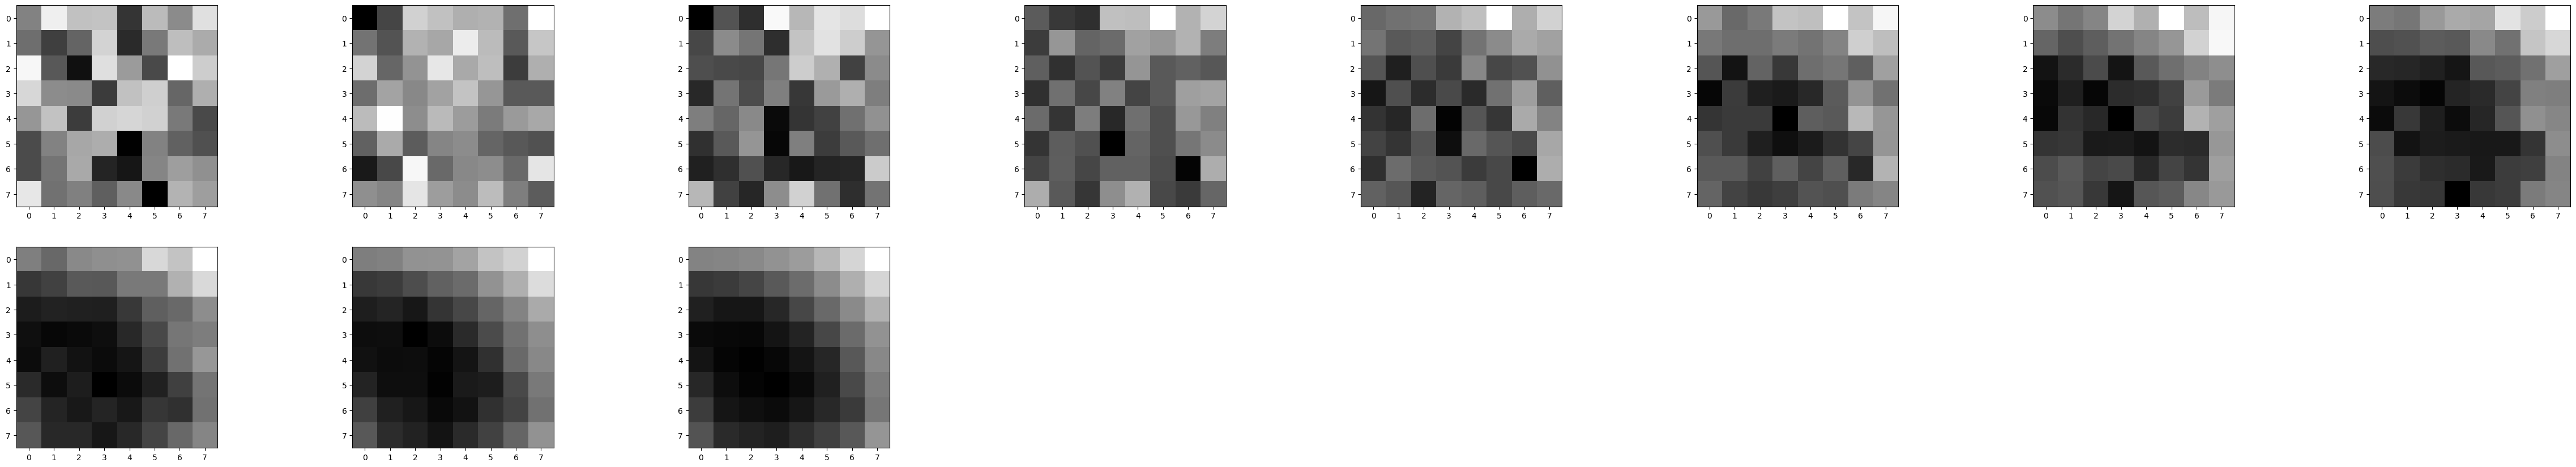

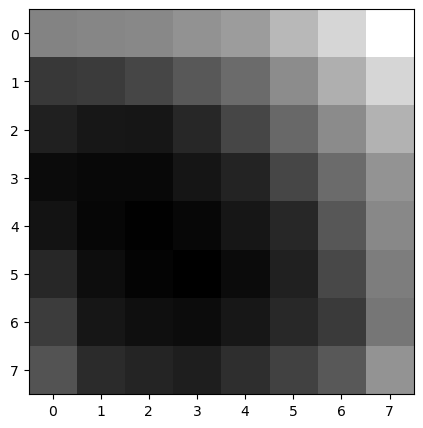

In [18]:
# VISUALIZE REVERSE PROCESS
plt.figure(figsize=(60,60))
num_step_images = 10
stepsize = int(num_timesteps/num_step_images)

tensors = tensor_sample[0]
for i, tensor in enumerate(tensors):
    if i % stepsize == 0:
        plt.subplot(int(num_step_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor), cmap="gray")
plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensors[-1]), cmap="gray")

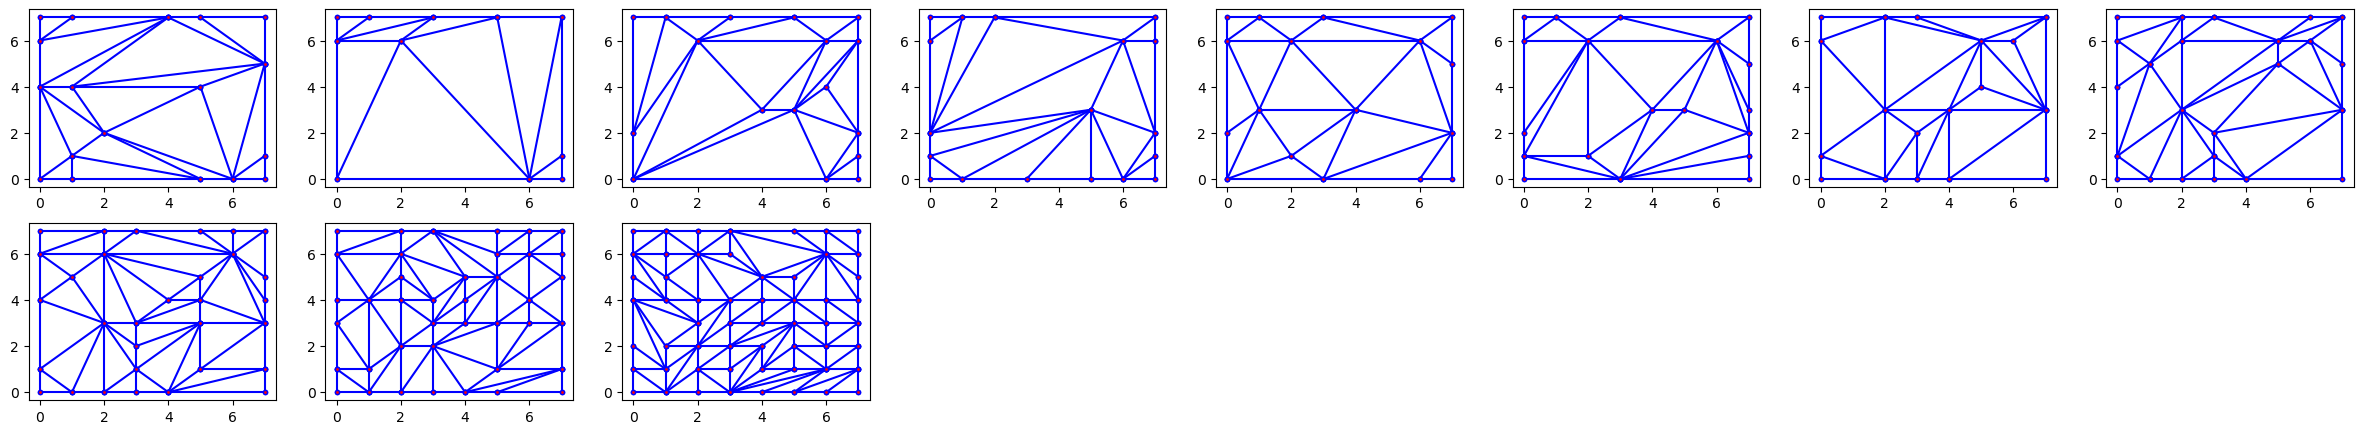

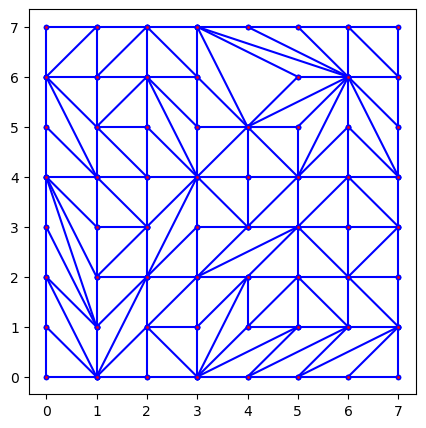

In [19]:
# Visualize triangulations

# Load triangulations
points_list = np.load(sample_dir + "points.pkl", allow_pickle=True)
simplices_list = np.load(sample_dir + "simplices.pkl", allow_pickle=True)

def Plot_2D_Triangulation(points, simplices):
    edges = np.unique(np.concatenate([((ss[0],ss[1]),(ss[0],ss[2]),(ss[1],ss[2])) for ss in simplices]),axis=0)
    x = points[:,0].flatten()
    y = points[:,1].flatten()
    return plt.plot(x[edges.T], y[edges.T], linestyle='-', color='b', markerfacecolor='red', marker='.')  
    

plt.figure(figsize=(30,30))
num_images = 10
num_timesteps = len(points_list)
stepsize = int(num_timesteps/num_images)

for idx in range(0, num_timesteps, stepsize):
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    Plot_2D_Triangulation(points_list[idx], simplices_list[idx])

plt.figure(figsize=(5,5))
Plot_2D_Triangulation(points_list[-1], simplices_list[-1])
plt.show()


100%|██████████| 1999/1999 [00:00<00:00, 162017.66it/s]


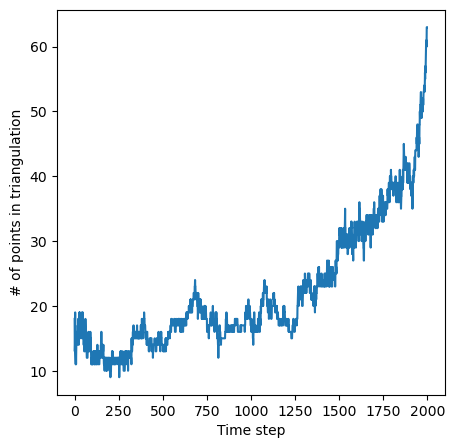

In [20]:
# Quantify fine-ness
point_counts = []
for s in tqdm(simplices_list):
    unique_points = np.unique(s.flatten())
    point_counts.append(len(unique_points))

plt.figure(figsize=(5,5))
plt.xlabel('Time step')
plt.ylabel('# of points in triangulation')
plt.plot(point_counts)

In [21]:
# Create gif
from PIL import Image
images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t in range(0, num_timesteps):
    if t % stepsize == 0:
        plt_figure = plt.figure(figsize=(2,2))
        plt.axis('off')
        Plot_2D_Triangulation(points_list[t], simplices_list[t])
        plt_figure.canvas.draw()
        image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
        images.append(image)
        plt.close()
images[0].save(gif_dir + '/triangulations.gif', save_all=True, append_images=images[1:], duration=50)

/tmp/ipykernel_145322/3473312628.py:12: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = Image.frombytes('RGB',plt_figure.canvas.get_width_height(),plt_figure.canvas.tostring_rgb())
